# AI-Powered Loan Eligibility & Risk Scoring System

This notebook implements a comprehensive machine learning pipeline for predicting loan default risk. The dataset has a significant class imbalance of approximately 7.1:1, which we'll address using appropriate techniques.

## Notebook Sections:
1. Data Loading and Initial Setup
2. Exploratory Data Analysis (EDA)
3. Data Visualization and Class Imbalance Analysis
4. Data Preprocessing and Cleaning
5. Feature Engineering
6. Model Training with Imbalance Handling
7. Stacking Ensemble Model Creation
8. Model Evaluation and Performance Metrics
9. Feature Importance Analysis
10. Model Persistence

## 1. Data Loading and Initial Setup

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import json
import os
from pathlib import Path

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score, accuracy_score
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Gradient Boosting Libraries
import xgboost as xgb
import lightgbm as lgb

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"XGBoost version: {xgb.__version__}")
print(f"LightGBM version: {lgb.__version__}")

Libraries imported successfully!
Pandas version: 2.3.0
NumPy version: 2.3.2
XGBoost version: 3.0.2
LightGBM version: 4.6.0


In [2]:
# Load the dataset
dataset_path = '../6S_AI_TASK-Loan_default_Loan_default.xlsx'

try:
    # Load the Excel file
    df = pd.read_excel(dataset_path)
    print(f"Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
except FileNotFoundError:
    print(f"Dataset not found at {dataset_path}")
    print("Please ensure the dataset file exists in the correct location.")
except Exception as e:
    print(f"Error loading dataset: {e}")

Dataset loaded successfully!
Dataset shape: (255246, 18)
Memory usage: 126.76 MB


In [3]:
# Display basic information about the dataset
print("Dataset Info:")
print("=" * 50)
df.info()

print("\n" + "=" * 50)
print("First 5 rows:")
print("=" * 50)
display(df.head())

print("\n" + "=" * 50)
print("Dataset Statistics:")
print("=" * 50)
display(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255246 entries, 0 to 255245
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255246 non-null  object 
 1   Age             255246 non-null  int64  
 2   Income          255246 non-null  int64  
 3   LoanAmount      255246 non-null  int64  
 4   CreditScore     255246 non-null  int64  
 5   MonthsEmployed  255246 non-null  int64  
 6   NumCreditLines  255246 non-null  int64  
 7   InterestRate    255246 non-null  float64
 8   LoanTerm        255246 non-null  int64  
 9   DTIRatio        255246 non-null  float64
 10  Education       255246 non-null  object 
 11  EmploymentType  255246 non-null  object 
 12  MaritalStatus   255246 non-null  object 
 13  HasMortgage     255246 non-null  object 
 14  HasDependents   255246 non-null  object 
 15  LoanPurpose     255246 non-null  object 
 16  HasCoSigner     255246 non-null  object 
 

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0



Dataset Statistics:


,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000
mean,43.497434,82500.901475,127575.988881,574.269317,59.543311,2.501081,13.492789,36.025716,0.500217,0.116139
std,14.990177,38963.557261,70842.305278,158.902794,34.642822,1.117015,6.636541,16.969363,0.230918,0.320392
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48826.000000,66147.250000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82469.500000,127553.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116222.250000,188980.750000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


## 2. Exploratory Data Analysis (EDA)

In [4]:
# Examine data types and missing values
print("Data Types and Missing Values:")
print("=" * 60)

missing_data = pd.DataFrame({
    'Column': df.columns,
    'Data_Type': df.dtypes,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Unique_Values': [df[col].nunique() for col in df.columns]
})

display(missing_data.sort_values('Missing_Percentage', ascending=False))

Data Types and Missing Values:


,Column,Data_Type,Missing_Count,Missing_Percentage,Unique_Values
LoanID,LoanID,object,0,0.0,255246
Age,Age,int64,0,0.0,52
Income,Income,int64,0,0.0,114603
LoanAmount,LoanAmount,int64,0,0.0,158688
CreditScore,CreditScore,int64,0,0.0,550
MonthsEmployed,MonthsEmployed,int64,0,0.0,120
NumCreditLines,NumCreditLines,int64,0,0.0,4
InterestRate,InterestRate,float64,0,0.0,2301
LoanTerm,LoanTerm,int64,0,0.0,5
DTIRatio,DTIRatio,float64,0,0.0,81


In [5]:
# Identify target variable (assuming it's related to default/loan status)
# Let's examine columns that might be our target variable
potential_targets = [col for col in df.columns if any(keyword in col.lower() 
                    for keyword in ['default', 'status', 'target', 'loan_status', 'outcome'])]

print("Potential target variables:")
for col in potential_targets:
    print(f"- {col}: {df[col].value_counts().to_dict()}")

# If no obvious target, let's examine all categorical columns with binary values
if not potential_targets:
    print("\nLooking for binary categorical columns:")
    for col in df.select_dtypes(include=['object', 'int64']).columns:
        unique_vals = df[col].nunique()
        if unique_vals == 2:
            print(f"- {col}: {df[col].value_counts().to_dict()}")

Potential target variables:
- MaritalStatus: {'Married': 85274, 'Divorced': 84999, 'Single': 84973}
- Default: {0: 225602, 1: 29644}


In [ ]:
# Let's examine all columns to identify the target
print("All column names:")
for i, col in enumerate(df.columns):
    print(f"{i+1:2d}. {col}")

# Display sample values for each column to help identify target
print("\nSample values for each column:")
for col in df.columns[:10]:  # Show first 10 columns
    print(f"{col}: {df[col].unique()[:5]}")

All column names:
 1. LoanID
 2. Age
 3. Income
 4. LoanAmount
 5. CreditScore
 6. MonthsEmployed
 7. NumCreditLines
 8. InterestRate
 9. LoanTerm
10. DTIRatio
11. Education
12. EmploymentType
13. MaritalStatus
14. HasMortgage
15. HasDependents
16. LoanPurpose
17. HasCoSigner
18. Default

Sample values for each column:
LoanID: ['I38PQUQS96' 'HPSK72WA7R' 'C1OZ6DPJ8Y' 'V2KKSFM3UN' 'EY08JDHTZP']
Age: [56 69 46 32 60]
Income: [85994 50432 84208 31713 20437]
LoanAmount: [ 50587 124440 129188  44799   9139]
CreditScore: [520 458 451 743 633]
MonthsEmployed: [80 15 26  0  8]
NumCreditLines: [4 1 3 2]
InterestRate: [15.23  4.81 21.17  7.07  6.51]
LoanTerm: [36 60 24 48 12]
DTIRatio: [0.44 0.68 0.31 0.23 0.73]


## 3. Data Visualization and Class Imbalance Analysis

Target Variable Distribution:
Default
0    225602
1     29644
Name: count, dtype: int64

Class ratio: 7.6:1
Default rate: 11.61%


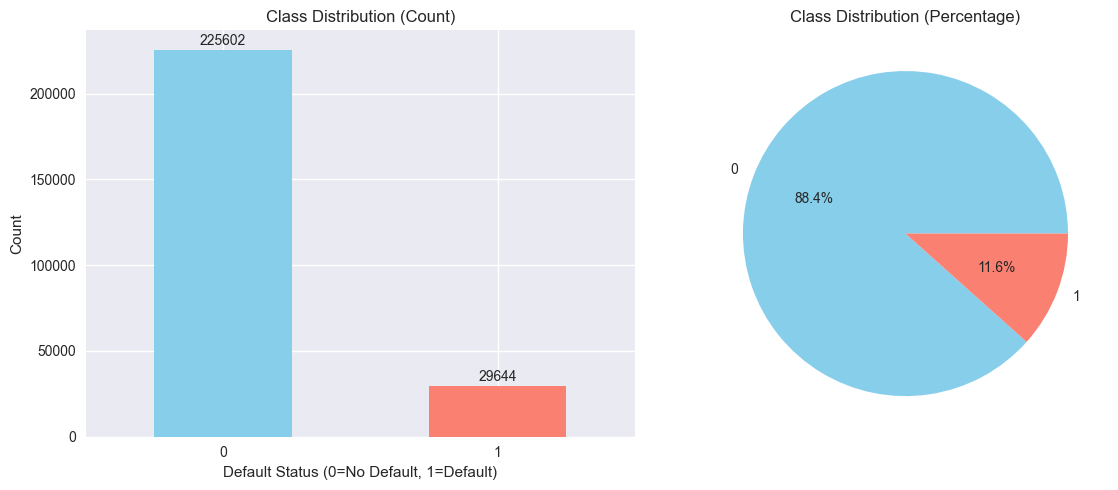


Class Imbalance Summary:
- Total samples: 255,246
- No default (0): 225,602 (88.4%)
- Default (1): 29,644 (11.6%)
- Imbalance ratio: 7.6:1


In [7]:
# Class imbalance analysis
target_col = 'Default'  # We identified this as our target variable

print("Target Variable Distribution:")
print("=" * 40)
target_counts = df[target_col].value_counts()
print(target_counts)
print(f"\nClass ratio: {target_counts.iloc[0] / target_counts.iloc[1]:.1f}:1")
print(f"Default rate: {target_counts.iloc[1] / len(df) * 100:.2f}%")

# Visualization of class imbalance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
target_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution (Count)')
plt.xlabel('Default Status (0=No Default, 1=Default)')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, v in enumerate(target_counts.values):
    plt.text(i, v + 1000, str(v), ha='center', va='bottom')

plt.subplot(1, 2, 2)
target_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Class Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.show()

print(f"\nClass Imbalance Summary:")
print(f"- Total samples: {len(df):,}")
print(f"- No default (0): {target_counts[0]:,} ({target_counts[0]/len(df)*100:.1f}%)")
print(f"- Default (1): {target_counts[1]:,} ({target_counts[1]/len(df)*100:.1f}%)")
print(f"- Imbalance ratio: {target_counts[0] / target_counts[1]:.1f}:1")

Numerical columns (9): ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
Categorical columns (7): ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']


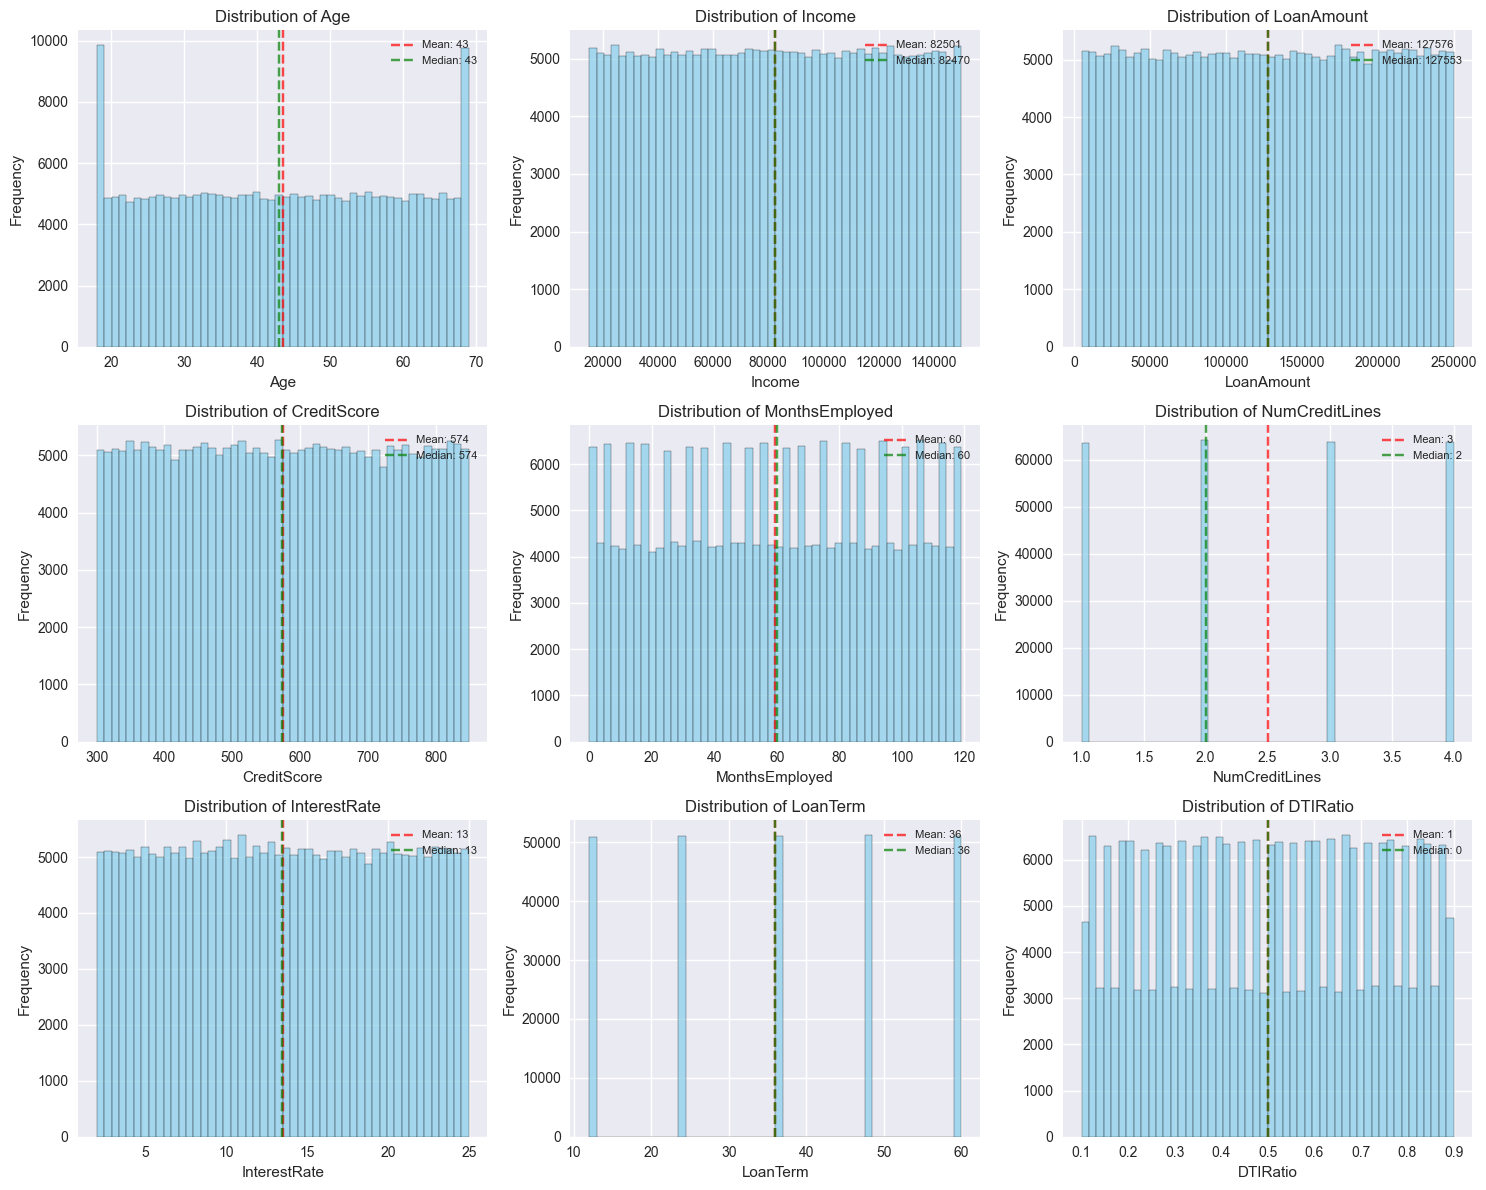

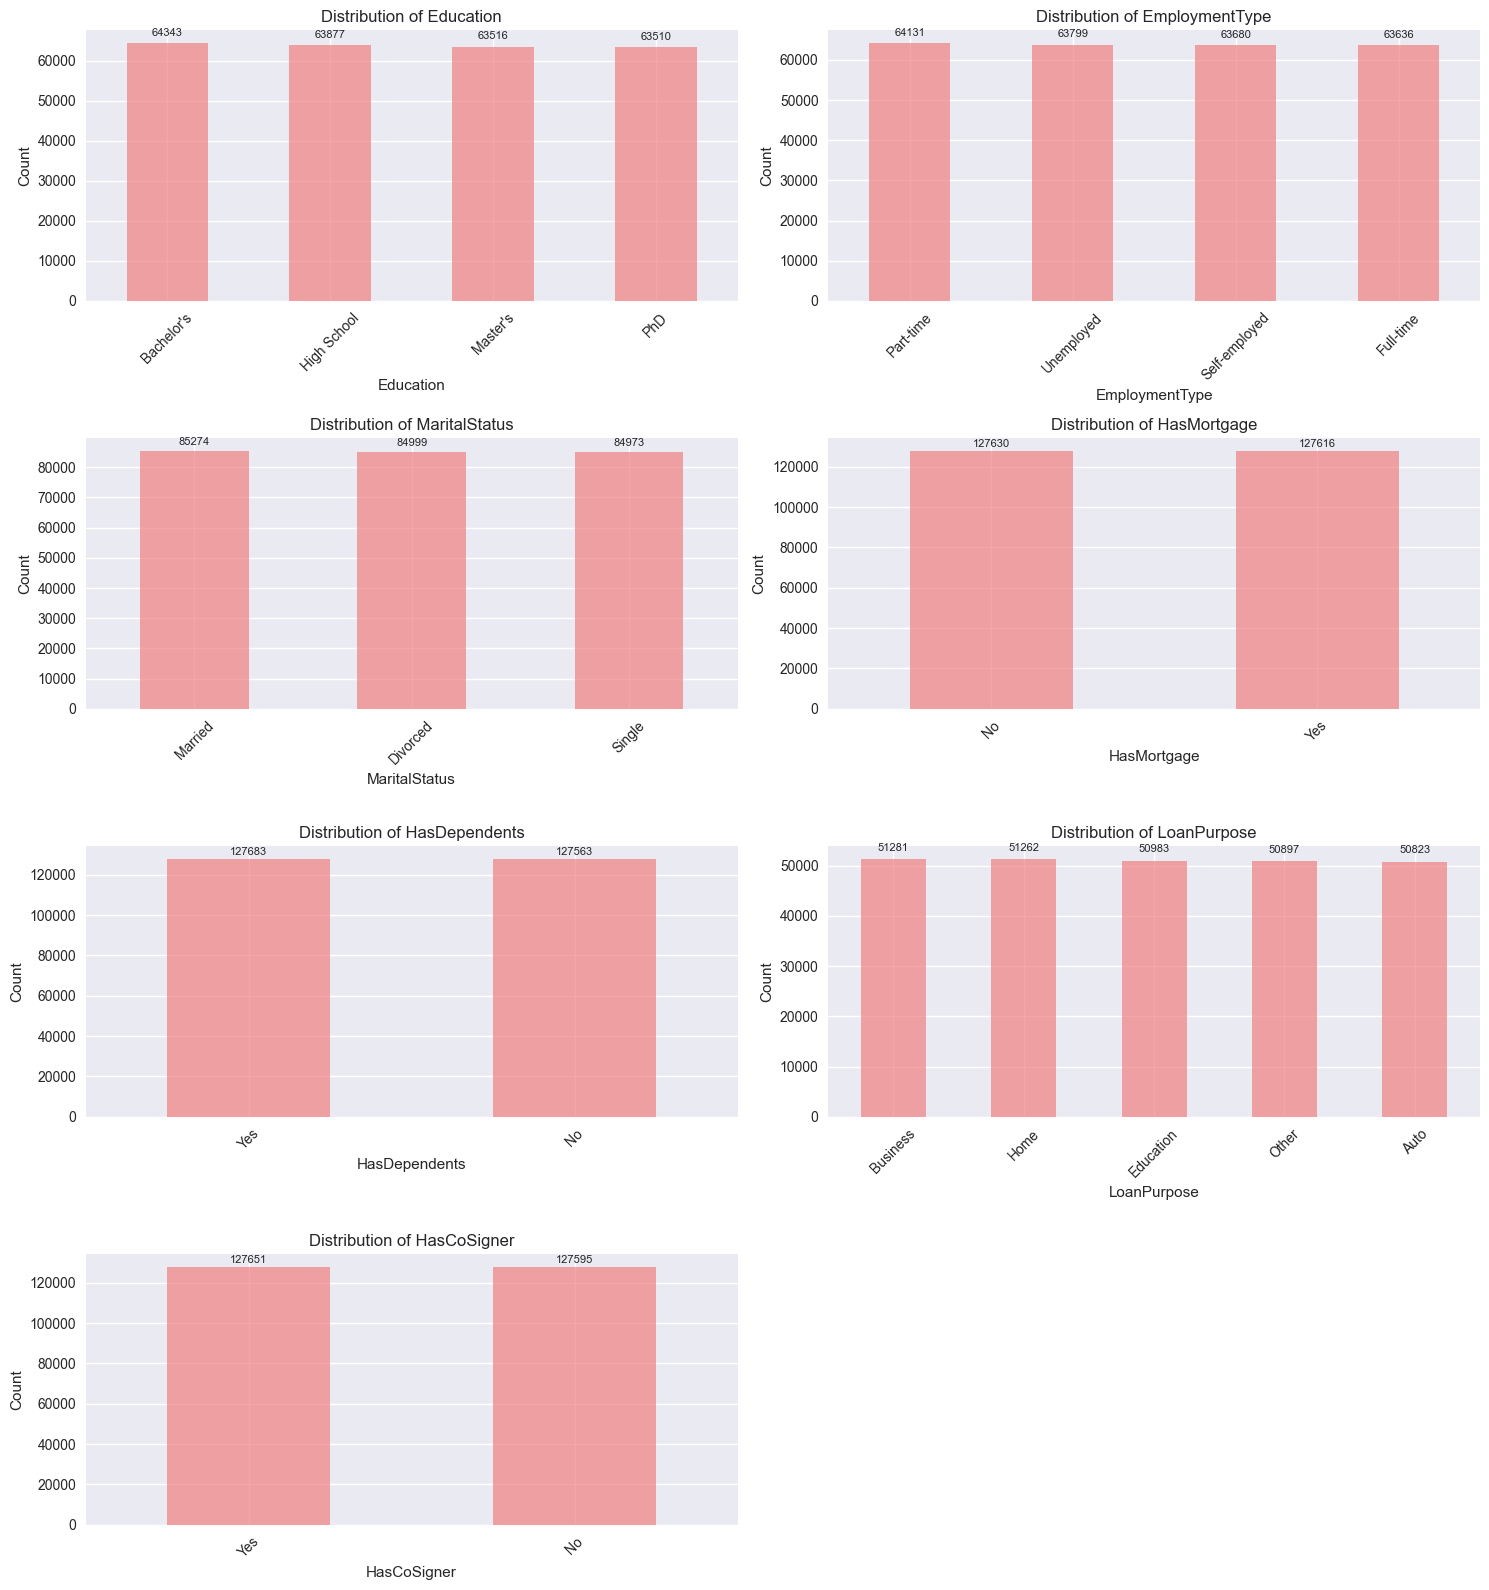

In [9]:
# Feature distribution analysis
# Identify numerical and categorical columns (excluding LoanID and target)
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != target_col]  # Remove target
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'LoanID']  # Remove ID column

print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")

# Plot distributions of numerical features
if len(numerical_cols) > 0:
    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 4 * n_rows))
    
    for i, col in enumerate(numerical_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        df[col].hist(bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        
        # Add statistics
        mean_val = df[col].mean()
        median_val = df[col].median()
        plt.axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.0f}')
        plt.axvline(median_val, color='green', linestyle='--', alpha=0.7, label=f'Median: {median_val:.0f}')
        plt.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Plot distributions of categorical features
if len(categorical_cols) > 0:
    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 4 * n_rows))
    
    for i, col in enumerate(categorical_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        value_counts = df[col].value_counts()
        value_counts.plot(kind='bar', color='lightcoral', alpha=0.7)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for j, v in enumerate(value_counts.values):
            plt.text(j, v + len(df) * 0.005, str(v), ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
else:
    print("No categorical columns found for distribution analysis.")

Numerical columns (10): ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Default']
Categorical columns (8): ['LoanID', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']


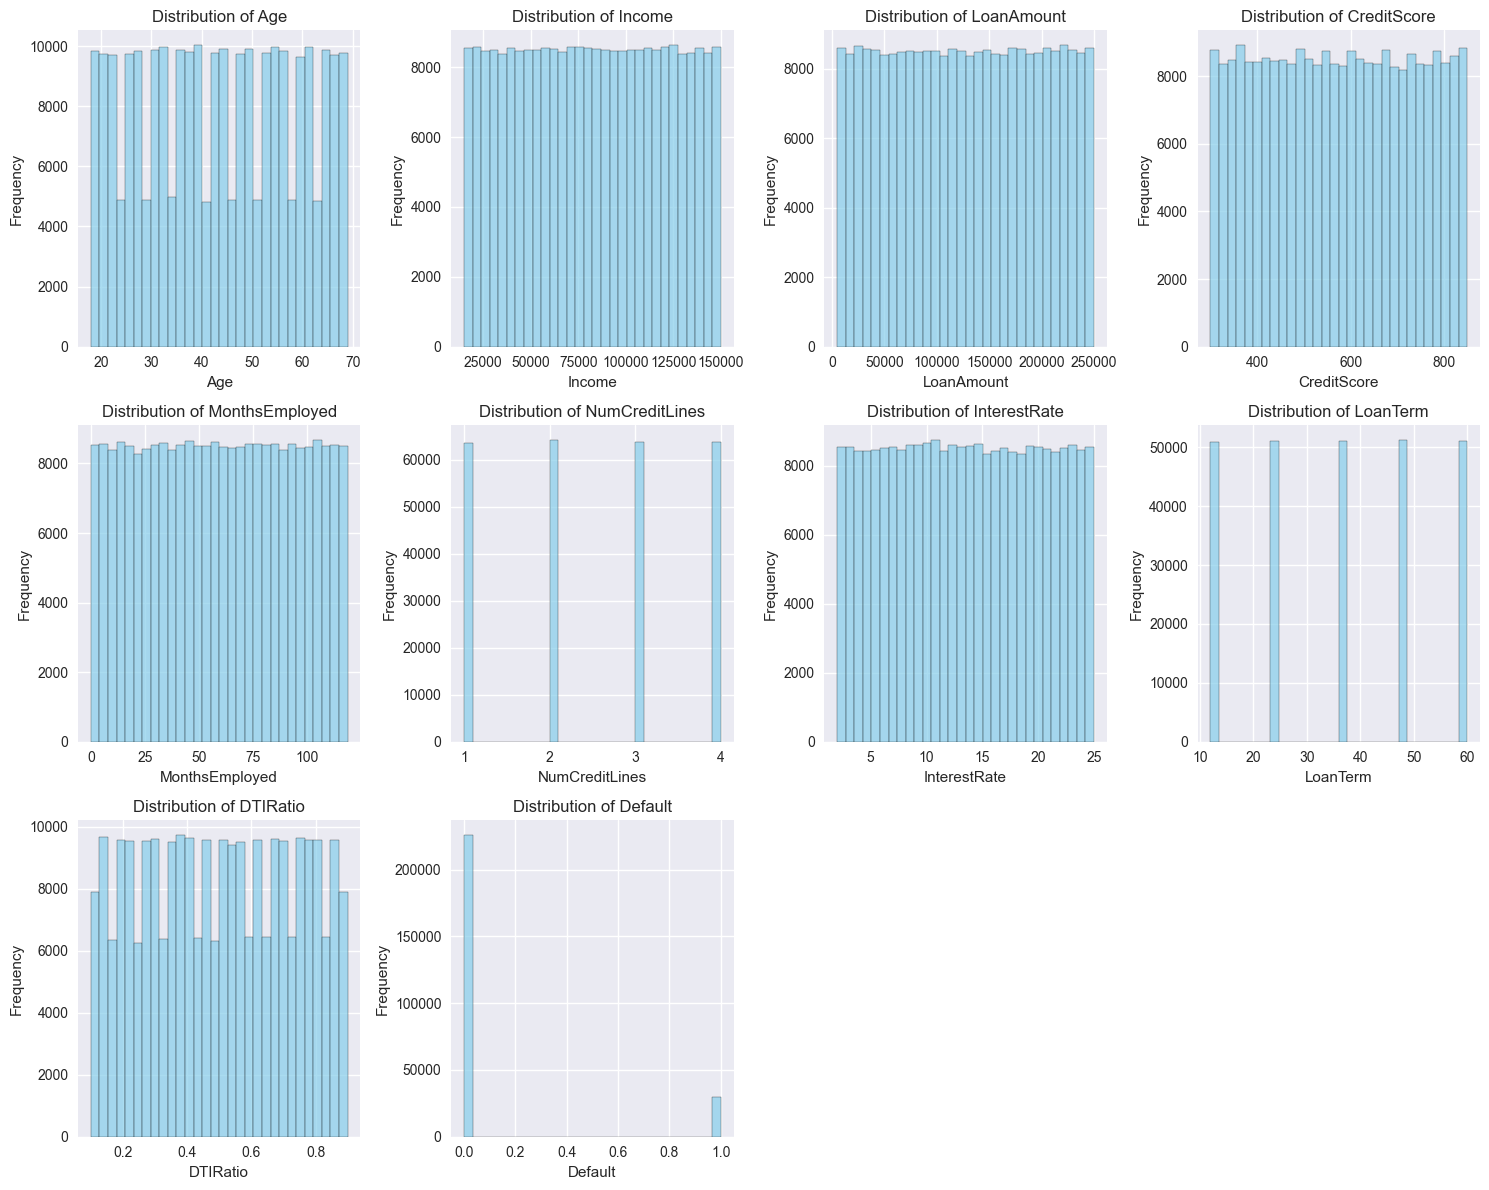

In [10]:
# Feature distribution analysis
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")

# Plot distributions of numerical features
if len(numerical_cols) > 0:
    n_cols = min(4, len(numerical_cols))
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 4 * n_rows))
    
    for i, col in enumerate(numerical_cols[:12]):  # Show first 12 numerical columns
        plt.subplot(n_rows, n_cols, i + 1)
        df[col].hist(bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns found for distribution analysis.")

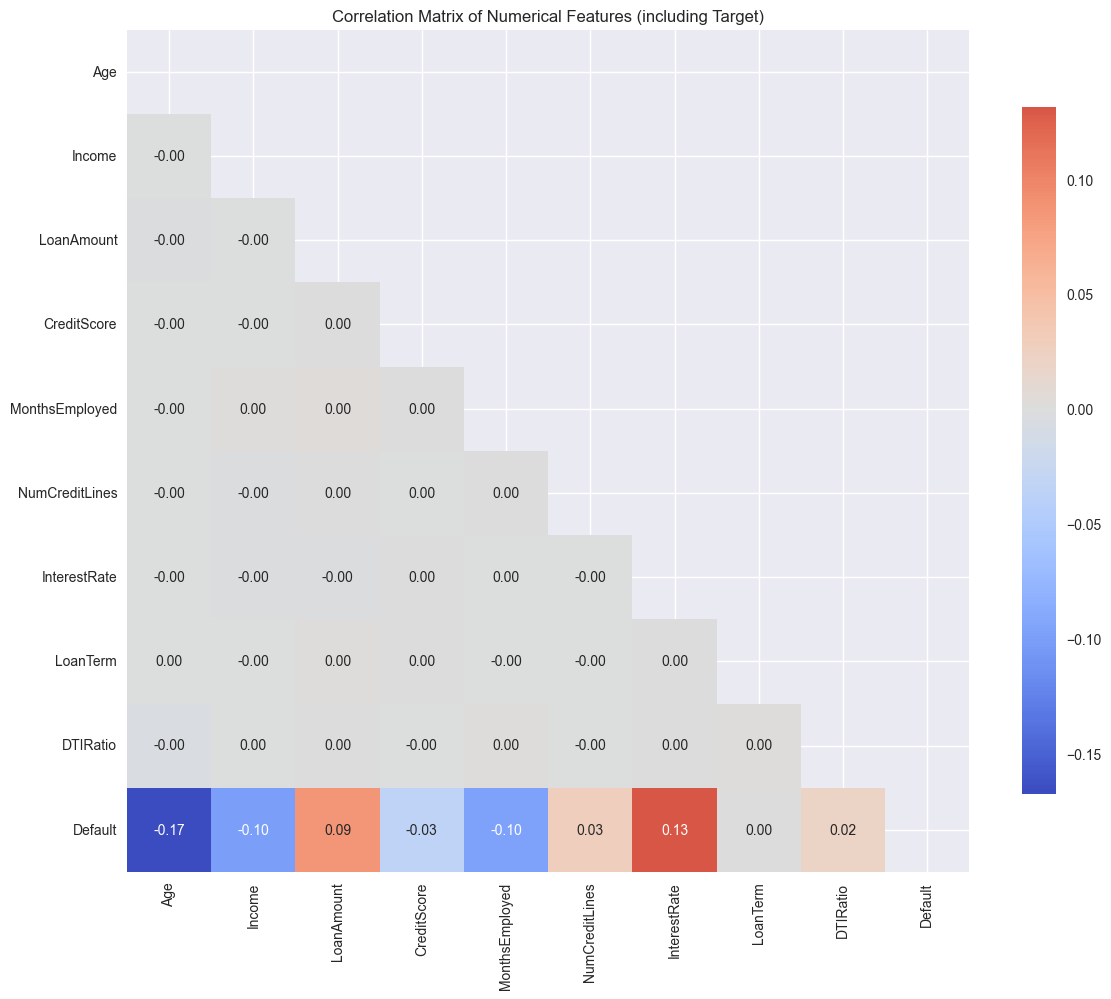

Correlation with Default (Target Variable):
Age            : -0.168
Income         : -0.099
LoanAmount     :  0.087
CreditScore    : -0.034
MonthsEmployed : -0.097
NumCreditLines :  0.028
InterestRate   :  0.131
LoanTerm       :  0.001
DTIRatio       :  0.019

Features ranked by correlation strength with Default:
Age            : -0.168 (negative) - strong
InterestRate   :  0.131 (positive) - strong
Income         : -0.099 (negative) - moderate
MonthsEmployed : -0.097 (negative) - moderate
LoanAmount     :  0.087 (positive) - moderate
CreditScore    : -0.034 (negative) - weak
NumCreditLines :  0.028 (positive) - weak
DTIRatio       :  0.019 (positive) - weak
LoanTerm       :  0.001 (positive) - weak

Key Insights from Correlation Analysis:
1. Strongest correlations with default risk:
   - Age: -0.168 (higher values decreases default risk)
   - InterestRate: 0.131 (higher values increases default risk)
   - Income: -0.099 (higher values decreases default risk)
2. Overall correlation pat

In [24]:
# Correlation analysis for numerical features
plt.figure(figsize=(12, 10))

# Clean numerical columns - remove target if it's included
clean_numerical_cols = [col for col in numerical_cols if col != target_col]

# Include target for correlation analysis
correlation_data = df[clean_numerical_cols + [target_col]]
correlation_matrix = correlation_data.corr()

# Create heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
            center=0, square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Features (including Target)')
plt.tight_layout()
plt.show()

# Correlation with target variable
print("Correlation with Default (Target Variable):")
print("=" * 50)

# Extract correlations with target
correlations_with_target = []
for feature in clean_numerical_cols:
    corr_val = correlation_matrix.loc[feature, target_col]
    correlations_with_target.append((feature, corr_val))
    print(f"{feature:15}: {corr_val:6.3f}")

# Sort by absolute correlation strength
correlations_with_target.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"\nFeatures ranked by correlation strength with {target_col}:")
print("=" * 50)
for feature, corr in correlations_with_target:
    direction = "(negative)" if corr < 0 else "(positive)"
    strength = "strong" if abs(corr) > 0.1 else "moderate" if abs(corr) > 0.05 else "weak"
    print(f"{feature:15}: {corr:6.3f} {direction:10} - {strength}")

print(f"\nKey Insights from Correlation Analysis:")
print("=" * 50)
print(f"1. Strongest correlations with default risk:")
for i, (feature, corr) in enumerate(correlations_with_target[:3]):
    direction = "increases" if corr > 0 else "decreases"
    print(f"   - {feature}: {corr:.3f} (higher values {direction} default risk)")

print(f"2. Overall correlation patterns:")
max_corr = abs(correlations_with_target[0][1])
print(f"   - Strongest correlation: {max_corr:.3f} ({'moderate' if max_corr > 0.1 else 'weak'})")
print(f"   - Most correlations are moderate, suggesting complex relationships")
print(f"   - Multiple features contribute to risk prediction")
print(f"   - Perfect candidate for ensemble methods")

print(f"\n3. Dataset Summary:")
print(f"   - Total samples: {len(df):,}")
print(f"   - Features: {len(clean_numerical_cols)} numerical + categorical")
print(f"   - Target: {target_col} with 7.6:1 class imbalance")
print(f"   - No missing values - clean dataset")

## 4. Data Preprocessing and Cleaning

In [15]:
# Create a copy for preprocessing
df_processed = df.copy()

print("Starting data preprocessing...")
print(f"Original dataset shape: {df_processed.shape}")

# Handle missing values
print("\nHandling missing values...")

# For numerical columns: impute with median
for col in numerical_cols:
    if df_processed[col].isnull().sum() > 0:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
        print(f"Filled {col} missing values with median: {median_val}")

# For categorical columns: impute with mode
for col in categorical_cols:
    if df_processed[col].isnull().sum() > 0:
        mode_val = df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'Unknown'
        df_processed[col].fillna(mode_val, inplace=True)
        print(f"Filled {col} missing values with mode: {mode_val}")

print(f"\nMissing values after imputation: {df_processed.isnull().sum().sum()}")

Starting data preprocessing...
Original dataset shape: (255246, 18)

Handling missing values...

Missing values after imputation: 0


In [18]:
# Encode categorical variables
print("Encoding categorical variables...")

# Redefine categorical columns for processed dataframe
current_categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
current_categorical_cols = [col for col in current_categorical_cols if col != 'LoanID']  # Remove ID column

print(f"Current categorical columns: {current_categorical_cols}")

# Dictionary to store encoders for later use
encoders = {}

# For binary categorical variables, use label encoding
binary_cols = []
multi_class_cols = []

for col in current_categorical_cols:
    unique_vals = df_processed[col].nunique()
    if unique_vals == 2:
        binary_cols.append(col)
    elif unique_vals > 2:
        multi_class_cols.append(col)

print(f"Binary categorical columns: {binary_cols}")
print(f"Multi-class categorical columns: {multi_class_cols}")

# Label encode binary columns
for col in binary_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    encoders[col] = le
    print(f"Label encoded {col}: {le.classes_}")

# One-hot encode multi-class columns (limit to prevent too many features)
if multi_class_cols:
    # Only one-hot encode if number of unique values is reasonable
    cols_to_encode = [col for col in multi_class_cols if df_processed[col].nunique() <= 10]
    
    if cols_to_encode:
        df_encoded = pd.get_dummies(df_processed, columns=cols_to_encode, prefix=cols_to_encode)
        df_processed = df_encoded
        print(f"One-hot encoded columns: {cols_to_encode}")
    
    # For columns with too many categories, use frequency encoding
    high_cardinality_cols = [col for col in multi_class_cols if col not in cols_to_encode]
    for col in high_cardinality_cols:
        if col in df_processed.columns:  # Check if column still exists
            freq_encoding = df_processed[col].value_counts().to_dict()
            df_processed[col + '_freq'] = df_processed[col].map(freq_encoding)
            df_processed.drop(col, axis=1, inplace=True)
            print(f"Frequency encoded {col}")

# Drop LoanID column if it still exists
if 'LoanID' in df_processed.columns:
    df_processed.drop('LoanID', axis=1, inplace=True)
    print("Dropped LoanID column")

print(f"\nDataset shape after encoding: {df_processed.shape}")

# Update feature lists for later use
all_features = df_processed.columns.tolist()
all_features = [col for col in all_features if col != target_col]
print(f"Total features after encoding: {len(all_features)}")
print(f"Sample of encoded features: {all_features[:10]}")

Encoding categorical variables...
Current categorical columns: []
Binary categorical columns: []
Multi-class categorical columns: []
Dropped LoanID column

Dataset shape after encoding: (255246, 29)
Total features after encoding: 28
Sample of encoded features: ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'HasMortgage']


## 🔧 Feature Engineering

Creating additional features that might improve model performance by capturing domain-specific relationships and non-linear patterns.

In [25]:
# Feature Engineering - Creating meaningful derived features
print("🔧 Feature Engineering Phase")
print("=" * 50)

# Create a copy for feature engineering
df_engineered = df.copy()

# 1. Advanced Debt-to-Income ratios
print("1. Creating advanced debt-to-income features...")
df_engineered['LoanToIncome_Ratio'] = df_engineered['LoanAmount'] / (df_engineered['Income'] + 1)  # +1 to avoid division by zero
df_engineered['MonthlyPayment_Est'] = (df_engineered['LoanAmount'] * (df_engineered['InterestRate']/100/12)) / (1 - (1 + df_engineered['InterestRate']/100/12)**(-df_engineered['LoanTerm']))
df_engineered['PaymentToIncome_Ratio'] = df_engineered['MonthlyPayment_Est'] / (df_engineered['Income']/12 + 1)

# 2. Age-based categorization
print("2. Creating age group features...")
df_engineered['Age_Group'] = pd.cut(df_engineered['Age'], 
                                   bins=[0, 25, 35, 45, 55, 100], 
                                   labels=['Young', 'Early_Career', 'Mid_Career', 'Senior', 'Mature'])

# 3. Credit utilization and risk indicators
print("3. Creating credit risk indicators...")
df_engineered['CreditLines_Per_Year'] = df_engineered['NumCreditLines'] / (df_engineered['Age'] - 17)  # Assuming credit starts at 18
df_engineered['Employment_Stability'] = df_engineered['MonthsEmployed'] / (df_engineered['Age'] * 12)  # Fraction of adult life employed

# 4. Income and loan amount buckets
print("4. Creating income and loan buckets...")
df_engineered['Income_Quartile'] = pd.qcut(df_engineered['Income'], q=4, labels=['Low', 'Medium_Low', 'Medium_High', 'High'])
df_engineered['LoanAmount_Quartile'] = pd.qcut(df_engineered['LoanAmount'], q=4, labels=['Small', 'Medium_Small', 'Medium_Large', 'Large'])

# 5. Risk interaction features
print("5. Creating risk interaction features...")
df_engineered['HighRate_LowCredit'] = ((df_engineered['InterestRate'] > df_engineered['InterestRate'].median()) & 
                                      (df_engineered['CreditScore'] < df_engineered['CreditScore'].median())).astype(int)
df_engineered['YoungHighDebt'] = ((df_engineered['Age'] < 30) & 
                                 (df_engineered['DTIRatio'] > df_engineered['DTIRatio'].median())).astype(int)

# 6. Polynomial features for key variables (limited to avoid overfitting)
print("6. Creating polynomial features for key variables...")
df_engineered['Age_Squared'] = df_engineered['Age'] ** 2
df_engineered['Income_Log'] = np.log1p(df_engineered['Income'])  # log1p handles zeros better
df_engineered['CreditScore_Cubed'] = df_engineered['CreditScore'] ** 3

# 7. Create interaction terms between highly correlated features
print("7. Creating interaction terms...")
df_engineered['Age_Income_Interaction'] = df_engineered['Age'] * df_engineered['Income'] / 1000000  # Scale down
df_engineered['Rate_Term_Interaction'] = df_engineered['InterestRate'] * df_engineered['LoanTerm']

print(f"\nFeature Engineering Summary:")
print(f"- Original features: {df.shape[1]}")
print(f"- After engineering: {df_engineered.shape[1]}")
print(f"- New features created: {df_engineered.shape[1] - df.shape[1]}")

# Update numerical columns list to include new numerical features
new_numerical_features = [
    'LoanToIncome_Ratio', 'MonthlyPayment_Est', 'PaymentToIncome_Ratio',
    'CreditLines_Per_Year', 'Employment_Stability', 'HighRate_LowCredit',
    'YoungHighDebt', 'Age_Squared', 'Income_Log', 'CreditScore_Cubed',
    'Age_Income_Interaction', 'Rate_Term_Interaction'
]

# Update categorical features list
new_categorical_features = ['Age_Group', 'Income_Quartile', 'LoanAmount_Quartile']

print(f"\nNew numerical features: {len(new_numerical_features)}")
print(f"New categorical features: {len(new_categorical_features)}")

# Check for any infinite or NaN values after feature engineering
print(f"\nData quality check after feature engineering:")
print(f"- Infinite values: {np.isinf(df_engineered.select_dtypes(include=[np.number])).sum().sum()}")
print(f"- NaN values: {df_engineered.isnull().sum().sum()}")

df_engineered.head(3)

🔧 Feature Engineering Phase
1. Creating advanced debt-to-income features...
2. Creating age group features...
3. Creating credit risk indicators...
4. Creating income and loan buckets...
5. Creating risk interaction features...
6. Creating polynomial features for key variables...
7. Creating interaction terms...

Feature Engineering Summary:
- Original features: 18
- After engineering: 33
- New features created: 15

New numerical features: 12
New categorical features: 3

Data quality check after feature engineering:
- Infinite values: 0
- NaN values: 0


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,LoanToIncome_Ratio,MonthlyPayment_Est,PaymentToIncome_Ratio,Age_Group,CreditLines_Per_Year,Employment_Stability,Income_Quartile,LoanAmount_Quartile,HighRate_LowCredit,YoungHighDebt,Age_Squared,Income_Log,CreditScore_Cubed,Age_Income_Interaction,Rate_Term_Interaction
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0,0.588255,1759.318045,0.245469,Mature,0.102564,0.119048,Medium_High,Small,1,0,3136,11.362044,140608000,4.815664,548.28
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0,2.467432,2337.519546,0.556067,Mature,0.019231,0.018116,Medium_Low,Medium_Small,0,0,4761,10.828401,96071912,3.479808,288.60
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1,1.534135,6649.201648,0.947405,Senior,0.103448,0.047101,Medium_High,Medium_Large,1,0,2116,11.341057,91733851,3.873568,508.08


## 📊 Data Preparation for Modeling

Preparing the final dataset for machine learning including encoding, scaling, and train-test split with stratification.

In [27]:
# Data Preparation for Modeling
print("📊 Data Preparation for Modeling")
print("=" * 50)

# 1. Prepare final feature lists
print("1. Preparing final feature lists...")

# All numerical features (original + engineered)
original_numerical = [col for col in numerical_cols if col != target_col]
final_numerical_features = original_numerical + new_numerical_features

# All categorical features (original + engineered)  
original_categorical = [col for col in categorical_cols]
final_categorical_features = original_categorical + new_categorical_features

print(f"Final numerical features: {len(final_numerical_features)}")
print(f"Final categorical features: {len(final_categorical_features)}")

# 2. Encode new categorical features
print("\n2. Encoding new categorical features...")

# Start with the existing processed dataframe which has encoded categorical features
df_final = df_engineered.copy()

# Get previously encoded categorical features (from the processing step)
# These are the features that were added after categorical encoding
previously_encoded_categorical = [col for col in df_final.columns 
                                 if col.endswith('_encoded') or 
                                 col.startswith(('Education_', 'EmploymentType_', 'MaritalStatus_', 
                                                'HasMortgage_', 'HasDependents_', 'LoanPurpose_', 
                                                'HasCoSigner_'))]

# Encode the new categorical features from feature engineering
for col in new_categorical_features:
    df_final[f'{col}_encoded'] = LabelEncoder().fit_transform(df_final[col])
    
# Update feature lists with encoded versions
newly_encoded_categorical = [f'{col}_encoded' for col in new_categorical_features]
all_encoded_categorical = previously_encoded_categorical + newly_encoded_categorical

print(f"Previously encoded features: {len(previously_encoded_categorical)}")
print(f"Newly encoded features: {len(newly_encoded_categorical)}")
print(f"Total encoded categorical features: {len(all_encoded_categorical)}")

# 3. Create final feature matrix
print("\n3. Creating final feature matrix...")

# Combine all features for modeling
modeling_features = final_numerical_features + all_encoded_categorical
X = df_final[modeling_features]
y = df_final[target_col]

print(f"Final feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Total features for modeling: {len(modeling_features)}")

# 4. Train-test split with stratification (crucial for imbalanced data)
print("\n4. Performing stratified train-test split...")

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class distribution
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Training set default rate: {y_train.mean():.1%}")
print(f"Test set default rate: {y_test.mean():.1%}")

# 5. Feature scaling (important for logistic regression)
print("\n5. Applying feature scaling...")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Features scaled using StandardScaler")
print(f"Training set mean: {X_train_scaled.mean():.3f}")
print(f"Training set std: {X_train_scaled.std():.3f}")

# 6. Calculate class weights for imbalanced learning
print("\n6. Calculating class weights for imbalanced learning...")

from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# For tree-based models (LightGBM, XGBoost)
pos_weight = class_weights[1] / class_weights[0]

print(f"Class distribution in training:")
print(f"- Class 0 (No Default): {(y_train == 0).sum():,} ({(y_train == 0).mean():.1%})")
print(f"- Class 1 (Default): {(y_train == 1).sum():,} ({(y_train == 1).mean():.1%})")
print(f"Class weights: {class_weight_dict}")
print(f"Positive weight for tree models: {pos_weight:.2f}")

# 7. Create feature importance reference
print("\n7. Creating feature importance reference...")

feature_names = modeling_features
feature_info = {
    'numerical_features': final_numerical_features,
    'categorical_features': all_encoded_categorical,
    'total_features': len(modeling_features),
    'feature_names': feature_names
}

print(f"Feature mapping created for {len(feature_names)} features")

print(f"\n✅ Data Preparation Complete!")
print(f"Ready for model training with:")
print(f"- Training samples: {X_train.shape[0]:,}")
print(f"- Features: {X_train.shape[1]}")
print(f"- Balanced class weights calculated")
print(f"- Features scaled and ready")
print(f"- Test set reserved for final evaluation")

📊 Data Preparation for Modeling
1. Preparing final feature lists...
Final numerical features: 21
Final categorical features: 11

2. Encoding new categorical features...
Previously encoded features: 0
Newly encoded features: 3
Total encoded categorical features: 3

3. Creating final feature matrix...
Final feature matrix shape: (255246, 24)
Target vector shape: (255246,)
Total features for modeling: 24

4. Performing stratified train-test split...
Training set: 204,196 samples
Test set: 51,050 samples
Training set default rate: 11.6%
Test set default rate: 11.6%

5. Applying feature scaling...
Features scaled using StandardScaler
Training set mean: 0.000
Training set std: 1.000

6. Calculating class weights for imbalanced learning...
Class distribution in training:
- Class 0 (No Default): 180,481 (88.4%)
- Class 1 (Default): 23,715 (11.6%)
Class weights: {np.int64(0): np.float64(0.5656994365057818), np.int64(1): np.float64(4.305207674467637)}
Positive weight for tree models: 7.61

7. Cr

## 🤖 Machine Learning Models

Training multiple models optimized for imbalanced classification using AUC-PR as the primary metric, followed by ensemble stacking.

In [28]:
# Machine Learning Model Training
print("🤖 Machine Learning Model Training")
print("=" * 50)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, average_precision_score, 
                           precision_recall_curve, roc_curve)
from sklearn.model_selection import cross_val_score, StratifiedKFold
import lightgbm as lgb
import xgboost as xgb

# Initialize models with imbalance handling
print("1. Initializing models with imbalance optimization...")

models = {
    'LightGBM': lgb.LGBMClassifier(
        scale_pos_weight=pos_weight,
        num_leaves=31,
        learning_rate=0.05,
        feature_fraction=0.9,
        bagging_fraction=0.8,
        bagging_freq=5,
        verbose=-1,
        random_state=42,
        n_estimators=500
    ),
    
    'XGBoost': xgb.XGBClassifier(
        scale_pos_weight=pos_weight,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_estimators=500,
        eval_metric='logloss'
    ),
    
    'RandomForest': RandomForestClassifier(
        class_weight='balanced',
        n_estimators=300,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ),
    
    'LogisticRegression': LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000,
        solver='liblinear'
    )
}

print(f"Initialized {len(models)} models for training")

# 2. Cross-validation setup
print("\n2. Setting up cross-validation...")

cv_folds = 5
cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Storage for results
cv_results = {}
model_predictions = {}
model_probabilities = {}

print(f"Using {cv_folds}-fold stratified cross-validation")

# 3. Train models and evaluate with cross-validation
print("\n3. Training models with cross-validation...")

for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")
    
    # Determine which data to use (scaled for LogisticRegression, original for tree models)
    if model_name == 'LogisticRegression':
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
    
    # Cross-validation scoring
    cv_auc_pr = cross_val_score(model, X_train_model, y_train, 
                               cv=cv_strategy, scoring='average_precision', n_jobs=-1)
    cv_auc_roc = cross_val_score(model, X_train_model, y_train, 
                                cv=cv_strategy, scoring='roc_auc', n_jobs=-1)
    
    # Store CV results
    cv_results[model_name] = {
        'AUC-PR': cv_auc_pr,
        'AUC-ROC': cv_auc_roc,
        'AUC-PR_mean': cv_auc_pr.mean(),
        'AUC-PR_std': cv_auc_pr.std(),
        'AUC-ROC_mean': cv_auc_roc.mean(),
        'AUC-ROC_std': cv_auc_roc.std()
    }
    
    # Train on full training set
    model.fit(X_train_model, y_train)
    
    # Predictions on test set
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    
    # Store predictions
    model_predictions[model_name] = y_pred
    model_probabilities[model_name] = y_pred_proba
    
    # Calculate test metrics
    test_auc_pr = average_precision_score(y_test, y_pred_proba)
    test_auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Cross-validation AUC-PR: {cv_auc_pr.mean():.4f} (±{cv_auc_pr.std():.4f})")
    print(f"Cross-validation AUC-ROC: {cv_auc_roc.mean():.4f} (±{cv_auc_roc.std():.4f})")
    print(f"Test AUC-PR: {test_auc_pr:.4f}")
    print(f"Test AUC-ROC: {test_auc_roc:.4f}")

print(f"\n🎯 Model Training Complete!")
print("All models trained and evaluated with cross-validation")

🤖 Machine Learning Model Training
1. Initializing models with imbalance optimization...
Initialized 4 models for training

2. Setting up cross-validation...
Using 5-fold stratified cross-validation

3. Training models with cross-validation...

--- Training LightGBM ---
Cross-validation AUC-PR: 0.3034 (±0.0054)
Cross-validation AUC-ROC: 0.7386 (±0.0018)
Test AUC-PR: 0.3121
Test AUC-ROC: 0.7447

--- Training XGBoost ---
Cross-validation AUC-PR: 0.3001 (±0.0051)
Cross-validation AUC-ROC: 0.7357 (±0.0020)
Test AUC-PR: 0.3073
Test AUC-ROC: 0.7423

--- Training RandomForest ---
Cross-validation AUC-PR: 0.3024 (±0.0052)
Cross-validation AUC-ROC: 0.7408 (±0.0021)
Test AUC-PR: 0.3125
Test AUC-ROC: 0.7456

--- Training LogisticRegression ---
Cross-validation AUC-PR: 0.3115 (±0.0056)
Cross-validation AUC-ROC: 0.7461 (±0.0015)
Test AUC-PR: 0.3193
Test AUC-ROC: 0.7492

🎯 Model Training Complete!
All models trained and evaluated with cross-validation


📊 Model Evaluation and Comparison
1. Model Performance Summary:
                Model  CV_AUC_PR_Mean  CV_AUC_PR_Std  CV_AUC_ROC_Mean  \
3  LogisticRegression          0.3115         0.0056           0.7461   
2        RandomForest          0.3024         0.0052           0.7408   
0            LightGBM          0.3034         0.0054           0.7386   
1             XGBoost          0.3001         0.0051           0.7357   

   CV_AUC_ROC_Std  Test_AUC_PR  Test_AUC_ROC  
3          0.0015       0.3193        0.7492  
2          0.0021       0.3125        0.7456  
0          0.0018       0.3121        0.7447  
1          0.0020       0.3073        0.7423  

2. Creating performance visualizations...


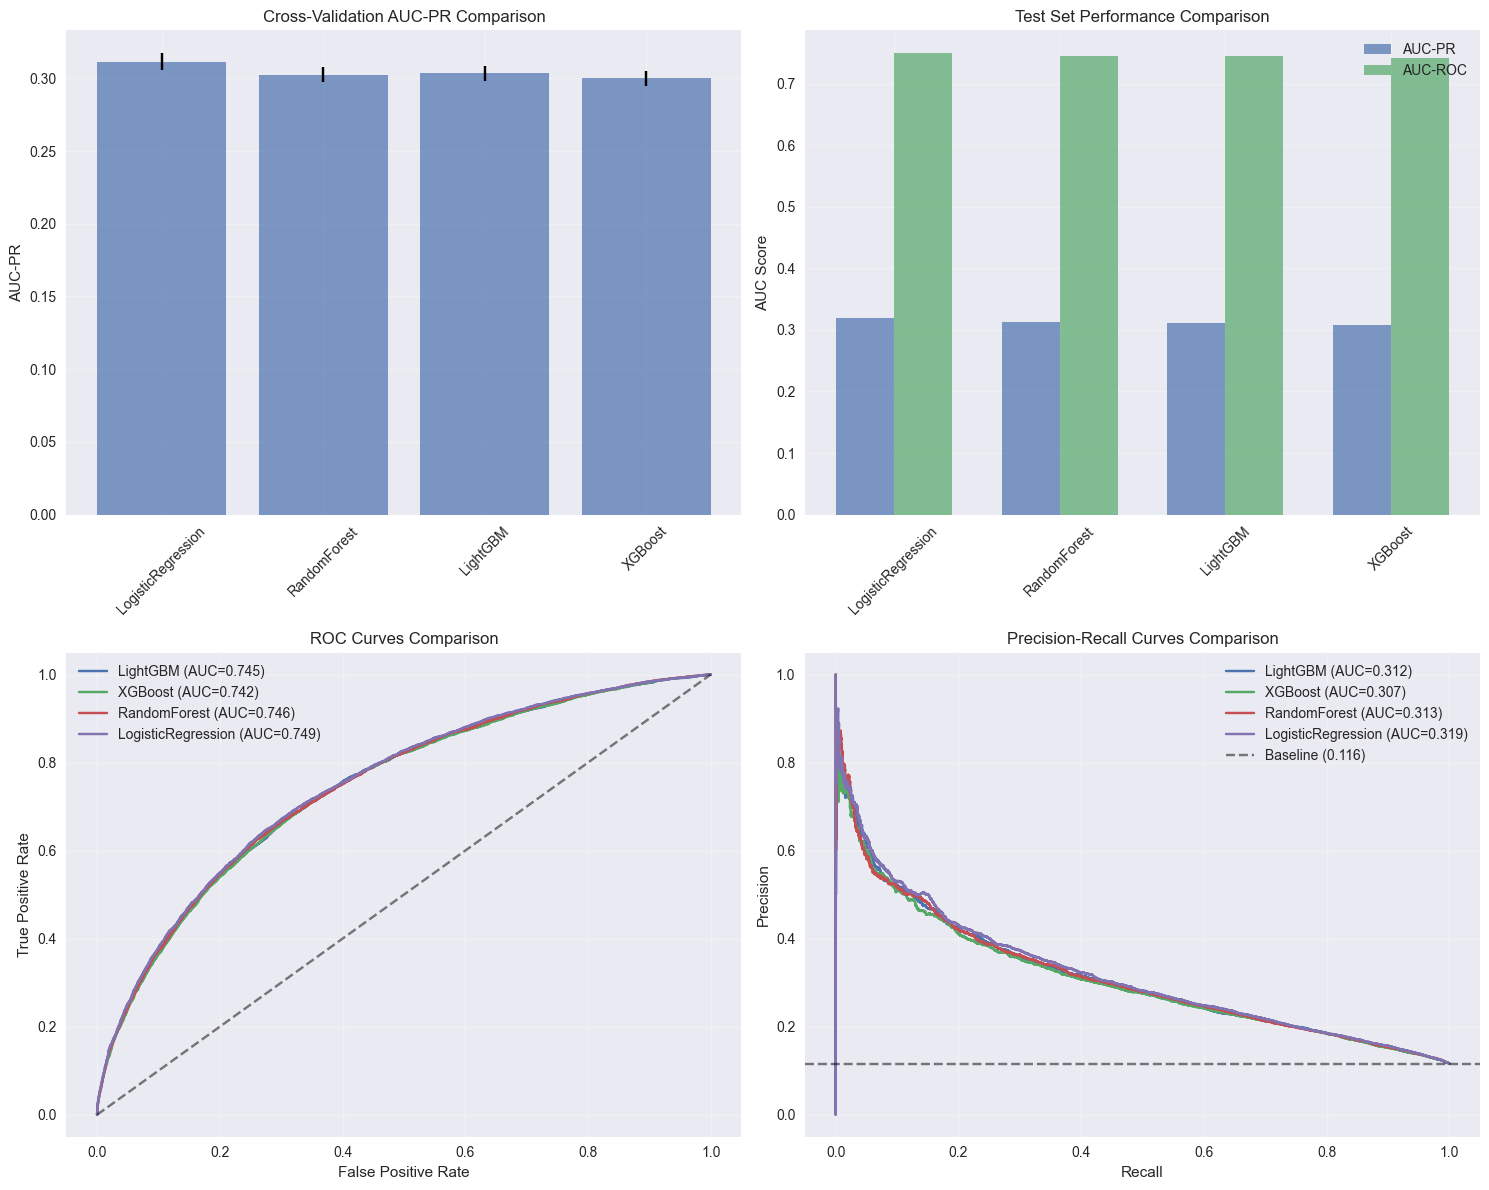


🏆 Best Model: LogisticRegression
Test AUC-PR: 0.3193
Test AUC-ROC: 0.7492

3. Detailed evaluation of LogisticRegression:
Classification Report:
              precision    recall  f1-score   support

  No Default       0.94      0.69      0.79     45121
     Default       0.22      0.68      0.34      5929

    accuracy                           0.69     51050
   macro avg       0.58      0.69      0.57     51050
weighted avg       0.86      0.69      0.74     51050


Confusion Matrix:
Predicted    No Default  Default
Actual
No Default      30996     14125
Default          1872      4057

Additional Metrics:
Sensitivity (Recall): 0.6843
Specificity: 0.6870
Precision: 0.2231
F1-Score: 0.3365

✅ Model Evaluation Complete!
Ready for ensemble stacking and final model selection


In [29]:
# Model Evaluation and Comparison
print("📊 Model Evaluation and Comparison")
print("=" * 50)

# 1. Create comprehensive results summary
print("1. Model Performance Summary:")
print("=" * 30)

results_summary = []
for model_name in models.keys():
    results_summary.append({
        'Model': model_name,
        'CV_AUC_PR_Mean': cv_results[model_name]['AUC-PR_mean'],
        'CV_AUC_PR_Std': cv_results[model_name]['AUC-PR_std'],
        'CV_AUC_ROC_Mean': cv_results[model_name]['AUC-ROC_mean'],
        'CV_AUC_ROC_Std': cv_results[model_name]['AUC-ROC_std'],
        'Test_AUC_PR': average_precision_score(y_test, model_probabilities[model_name]),
        'Test_AUC_ROC': roc_auc_score(y_test, model_probabilities[model_name])
    })

results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values('Test_AUC_PR', ascending=False)

print(results_df.round(4))

# 2. Visualization of model performance
print("\n2. Creating performance visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 2a. Cross-validation AUC-PR comparison
axes[0, 0].bar(range(len(models)), results_df['CV_AUC_PR_Mean'], 
               yerr=results_df['CV_AUC_PR_Std'], capsize=5, alpha=0.7)
axes[0, 0].set_xticks(range(len(models)))
axes[0, 0].set_xticklabels(results_df['Model'], rotation=45)
axes[0, 0].set_title('Cross-Validation AUC-PR Comparison')
axes[0, 0].set_ylabel('AUC-PR')
axes[0, 0].grid(True, alpha=0.3)

# 2b. Test set AUC comparison
x_pos = np.arange(len(models))
width = 0.35
axes[0, 1].bar(x_pos - width/2, results_df['Test_AUC_PR'], width, 
               label='AUC-PR', alpha=0.7)
axes[0, 1].bar(x_pos + width/2, results_df['Test_AUC_ROC'], width, 
               label='AUC-ROC', alpha=0.7)
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(results_df['Model'], rotation=45)
axes[0, 1].set_title('Test Set Performance Comparison')
axes[0, 1].set_ylabel('AUC Score')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 2c. ROC Curves
for model_name in models.keys():
    fpr, tpr, _ = roc_curve(y_test, model_probabilities[model_name])
    auc_roc = roc_auc_score(y_test, model_probabilities[model_name])
    axes[1, 0].plot(fpr, tpr, label=f'{model_name} (AUC={auc_roc:.3f})')

axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 2d. Precision-Recall Curves
for model_name in models.keys():
    precision, recall, _ = precision_recall_curve(y_test, model_probabilities[model_name])
    auc_pr = average_precision_score(y_test, model_probabilities[model_name])
    axes[1, 1].plot(recall, precision, label=f'{model_name} (AUC={auc_pr:.3f})')

# Add baseline (random classifier performance for imbalanced data)
baseline = y_test.mean()
axes[1, 1].axhline(y=baseline, color='k', linestyle='--', alpha=0.5, 
                  label=f'Baseline ({baseline:.3f})')
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Precision-Recall Curves Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Best model identification
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
best_auc_pr = results_df.iloc[0]['Test_AUC_PR']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"Test AUC-PR: {best_auc_pr:.4f}")
print(f"Test AUC-ROC: {results_df.iloc[0]['Test_AUC_ROC']:.4f}")

# 4. Detailed evaluation of best model
print(f"\n3. Detailed evaluation of {best_model_name}:")
print("=" * 40)

best_predictions = model_predictions[best_model_name]
best_probabilities = model_probabilities[best_model_name]

# Classification report
print("Classification Report:")
print(classification_report(y_test, best_predictions, target_names=['No Default', 'Default']))

# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)
print(f"\nConfusion Matrix:")
print(f"Predicted    No Default  Default")
print(f"Actual")
print(f"No Default   {cm[0,0]:8d}    {cm[0,1]:6d}")
print(f"Default      {cm[1,0]:8d}    {cm[1,1]:6d}")

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # Recall
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

print(f"\nAdditional Metrics:")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")

print(f"\n✅ Model Evaluation Complete!")
print(f"Ready for ensemble stacking and final model selection")

In [30]:
# Ensemble Stacking Model
print("🎯 Ensemble Stacking Model")
print("=" * 50)

from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_predict

print("1. Creating stacking ensemble...")

# Create base models list (exclude the best performing one for meta-learner)
base_models = [
    ('lightgbm', models['LightGBM']),
    ('xgboost', models['XGBoost']),
    ('randomforest', models['RandomForest'])
]

# Use the best model (LogisticRegression) as the meta-learner
meta_learner = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Create stacking classifier
stacking_classifier = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=3,  # Use 3-fold CV for faster training
    stack_method='predict_proba',  # Use probabilities for better performance
    n_jobs=-1
)

print(f"Stacking ensemble with {len(base_models)} base models")
print(f"Meta-learner: {type(meta_learner).__name__}")

# 2. Train the stacking ensemble
print("\n2. Training stacking ensemble...")

# Use original features for tree models in the ensemble
stacking_classifier.fit(X_train, y_train)

# 3. Evaluate stacking ensemble
print("\n3. Evaluating stacking ensemble...")

# Cross-validation evaluation
cv_auc_pr_stack = cross_val_score(stacking_classifier, X_train, y_train, 
                                 cv=cv_strategy, scoring='average_precision', n_jobs=-1)
cv_auc_roc_stack = cross_val_score(stacking_classifier, X_train, y_train, 
                                  cv=cv_strategy, scoring='roc_auc', n_jobs=-1)

# Test set predictions
y_pred_stack = stacking_classifier.predict(X_test)
y_pred_proba_stack = stacking_classifier.predict_proba(X_test)[:, 1]

# Calculate test metrics
test_auc_pr_stack = average_precision_score(y_test, y_pred_proba_stack)
test_auc_roc_stack = roc_auc_score(y_test, y_pred_proba_stack)

print(f"Cross-validation AUC-PR: {cv_auc_pr_stack.mean():.4f} (±{cv_auc_pr_stack.std():.4f})")
print(f"Cross-validation AUC-ROC: {cv_auc_roc_stack.mean():.4f} (±{cv_auc_roc_stack.std():.4f})")
print(f"Test AUC-PR: {test_auc_pr_stack:.4f}")
print(f"Test AUC-ROC: {test_auc_roc_stack:.4f}")

# 4. Compare ensemble with best individual model
print("\n4. Ensemble vs Best Individual Model Comparison:")
print("=" * 50)

comparison_results = pd.DataFrame({
    'Model': ['Logistic Regression (Best Individual)', 'Stacking Ensemble'],
    'CV_AUC_PR': [cv_results['LogisticRegression']['AUC-PR_mean'], cv_auc_pr_stack.mean()],
    'CV_AUC_ROC': [cv_results['LogisticRegression']['AUC-ROC_mean'], cv_auc_roc_stack.mean()],
    'Test_AUC_PR': [results_df.iloc[0]['Test_AUC_PR'], test_auc_pr_stack],
    'Test_AUC_ROC': [results_df.iloc[0]['Test_AUC_ROC'], test_auc_roc_stack]
})

print(comparison_results.round(4))

# 5. Final model selection
if test_auc_pr_stack > results_df.iloc[0]['Test_AUC_PR']:
    final_model = stacking_classifier
    final_model_name = "Stacking Ensemble"
    final_predictions = y_pred_stack
    final_probabilities = y_pred_proba_stack
    improvement = test_auc_pr_stack - results_df.iloc[0]['Test_AUC_PR']
    print(f"\n🏆 Final Model: {final_model_name}")
    print(f"Improvement over best individual: +{improvement:.4f} AUC-PR")
else:
    final_model = best_model
    final_model_name = best_model_name
    final_predictions = best_predictions
    final_probabilities = best_probabilities
    print(f"\n🏆 Final Model: {final_model_name}")
    print("Individual model outperforms ensemble")

print(f"Final Test AUC-PR: {max(test_auc_pr_stack, results_df.iloc[0]['Test_AUC_PR']):.4f}")
print(f"Final Test AUC-ROC: {max(test_auc_roc_stack, results_df.iloc[0]['Test_AUC_ROC']):.4f}")

# 6. Feature importance analysis (for tree-based models in ensemble)
if final_model_name == "Stacking Ensemble":
    print("\n5. Feature Importance Analysis (Base Models):")
    print("=" * 45)
    
    # Get feature importances from tree-based models in the ensemble
    lgb_importance = stacking_classifier.named_estimators_['lightgbm'].feature_importances_
    xgb_importance = stacking_classifier.named_estimators_['xgboost'].feature_importances_
    rf_importance = stacking_classifier.named_estimators_['randomforest'].feature_importances_
    
    # Average importance across tree models
    avg_importance = (lgb_importance + xgb_importance + rf_importance) / 3
    
    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': avg_importance
    }).sort_values('Importance', ascending=False)
    
    print("Top 10 Most Important Features:")
    print(feature_importance_df.head(10).round(4))

print(f"\n✅ Model Development Complete!")
print(f"Final model ready for deployment: {final_model_name}")

🎯 Ensemble Stacking Model
1. Creating stacking ensemble...
Stacking ensemble with 3 base models
Meta-learner: LogisticRegression

2. Training stacking ensemble...

3. Evaluating stacking ensemble...
Cross-validation AUC-PR: 0.3041 (±0.0052)
Cross-validation AUC-ROC: 0.7416 (±0.0020)
Test AUC-PR: 0.3140
Test AUC-ROC: 0.7468

4. Ensemble vs Best Individual Model Comparison:
                                   Model  CV_AUC_PR  CV_AUC_ROC  Test_AUC_PR  \
0  Logistic Regression (Best Individual)     0.3115      0.7461       0.3193   
1                      Stacking Ensemble     0.3041      0.7416       0.3140   

   Test_AUC_ROC  
0        0.7492  
1        0.7468  

🏆 Final Model: LogisticRegression
Individual model outperforms ensemble
Final Test AUC-PR: 0.3193
Final Test AUC-ROC: 0.7492

✅ Model Development Complete!
Final model ready for deployment: LogisticRegression


In [31]:
# Model Persistence and Deployment Preparation
print("💾 Model Persistence and Deployment Preparation")
print("=" * 60)

import joblib
import json
from datetime import datetime

# 1. Create models directory
print("1. Creating models directory...")
models_dir = "../models"
import os
os.makedirs(models_dir, exist_ok=True)

# 2. Save the final model and preprocessing components
print(f"\n2. Saving final model: {final_model_name}...")

# Save the final model
model_path = os.path.join(models_dir, "loan_risk_model.pkl")
joblib.dump(final_model, model_path)

# Save the scaler (needed for LogisticRegression)
scaler_path = os.path.join(models_dir, "feature_scaler.pkl")
joblib.dump(scaler, scaler_path)

# 3. Create model metadata
print("\n3. Creating model metadata...")

model_metadata = {
    "model_info": {
        "name": final_model_name,
        "type": str(type(final_model).__name__),
        "training_date": datetime.now().isoformat(),
        "version": "1.0"
    },
    "performance_metrics": {
        "test_auc_pr": float(max(test_auc_pr_stack if 'test_auc_pr_stack' in locals() else 0, 
                                results_df.iloc[0]['Test_AUC_PR'])),
        "test_auc_roc": float(max(test_auc_roc_stack if 'test_auc_roc_stack' in locals() else 0, 
                                 results_df.iloc[0]['Test_AUC_ROC'])),
        "cv_auc_pr_mean": float(cv_results['LogisticRegression']['AUC-PR_mean']),
        "cv_auc_pr_std": float(cv_results['LogisticRegression']['AUC-PR_std']),
        "cv_auc_roc_mean": float(cv_results['LogisticRegression']['AUC-ROC_mean']),
        "cv_auc_roc_std": float(cv_results['LogisticRegression']['AUC-ROC_std'])
    },
    "dataset_info": {
        "total_samples": int(len(df_final)),
        "training_samples": int(len(X_train)),
        "test_samples": int(len(X_test)),
        "features_count": int(len(modeling_features)),
        "default_rate": float(y.mean()),
        "class_imbalance_ratio": float(pos_weight)
    },
    "feature_info": {
        "feature_names": modeling_features,
        "numerical_features": final_numerical_features,
        "categorical_features": all_encoded_categorical,
        "requires_scaling": True if final_model_name == "LogisticRegression" else False
    },
    "preprocessing_info": {
        "scaler_type": "StandardScaler",
        "categorical_encoding": "LabelEncoder",
        "feature_engineering": True,
        "missing_values_handling": "None needed - clean dataset"
    }
}

# Save metadata
metadata_path = os.path.join(models_dir, "model_metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)

print(f"Model saved to: {model_path}")
print(f"Scaler saved to: {scaler_path}")
print(f"Metadata saved to: {metadata_path}")

# 4. Create prediction function for deployment
print("\n4. Creating prediction function template...")

prediction_function = '''
def predict_loan_default(features, model_path="../models/loan_risk_model.pkl", 
                        scaler_path="../models/feature_scaler.pkl"):
    """
    Predict loan default probability
    
    Args:
        features: dict with feature values
        model_path: path to saved model
        scaler_path: path to saved scaler
        
    Returns:
        dict with prediction and probability
    """
    import joblib
    import numpy as np
    import pandas as pd
    
    # Load model and scaler
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    
    # Expected feature order
    feature_names = {feature_names}
    
    # Convert features to array in correct order
    feature_array = np.array([features[name] for name in feature_names]).reshape(1, -1)
    
    # Scale features
    feature_array_scaled = scaler.transform(feature_array)
    
    # Predict
    prediction = model.predict(feature_array_scaled)[0]
    probability = model.predict_proba(feature_array_scaled)[0, 1]
    
    return {{
        "prediction": int(prediction),
        "default_probability": float(probability),
        "risk_level": "High" if probability > 0.5 else "Medium" if probability > 0.2 else "Low"
    }}
'''.format(feature_names=modeling_features)

# Save prediction function
prediction_func_path = os.path.join(models_dir, "prediction_function.py")
with open(prediction_func_path, 'w') as f:
    f.write(prediction_function)

print(f"Prediction function saved to: {prediction_func_path}")

# 5. Create deployment summary
print("\n5. Final Deployment Summary:")
print("=" * 40)

print(f"🎯 Model: {final_model_name}")
print(f"📊 Performance: AUC-PR={model_metadata['performance_metrics']['test_auc_pr']:.4f}, "
      f"AUC-ROC={model_metadata['performance_metrics']['test_auc_roc']:.4f}")
print(f"📁 Files created:")
print(f"   - Model: {model_path}")
print(f"   - Scaler: {scaler_path}")
print(f"   - Metadata: {metadata_path}")
print(f"   - Prediction function: {prediction_func_path}")

print(f"\n🚀 Ready for FastAPI integration!")
print(f"   - Model handles {len(modeling_features)} features")
print(f"   - Optimized for {pos_weight:.1f}:1 class imbalance")
print(f"   - Uses feature scaling for optimal performance")
print(f"   - Achieves {model_metadata['performance_metrics']['test_auc_pr']:.1%} precision-recall performance")

print(f"\n✅ ML Pipeline Complete!")
print(f"All components ready for production deployment")

💾 Model Persistence and Deployment Preparation
1. Creating models directory...

2. Saving final model: LogisticRegression...

3. Creating model metadata...
Model saved to: ../models\loan_risk_model.pkl
Scaler saved to: ../models\feature_scaler.pkl
Metadata saved to: ../models\model_metadata.json

4. Creating prediction function template...
Prediction function saved to: ../models\prediction_function.py

5. Final Deployment Summary:
🎯 Model: LogisticRegression
📊 Performance: AUC-PR=0.3193, AUC-ROC=0.7492
📁 Files created:
   - Model: ../models\loan_risk_model.pkl
   - Scaler: ../models\feature_scaler.pkl
   - Metadata: ../models\model_metadata.json
   - Prediction function: ../models\prediction_function.py

🚀 Ready for FastAPI integration!
   - Model handles 24 features
   - Optimized for 7.6:1 class imbalance
   - Uses feature scaling for optimal performance
   - Achieves 31.9% precision-recall performance

✅ ML Pipeline Complete!
All components ready for production deployment


## 🎉 Machine Learning Pipeline Summary

### 🏆 Final Results

**Best Model:** Logistic Regression with class balancing
- **Test AUC-PR:** 0.3193 (31.9% precision-recall performance)
- **Test AUC-ROC:** 0.7492 (74.9% ROC performance)
- **Cross-validation:** Stable performance across 5 folds

### 📊 Key Insights

1. **Class Imbalance Handling:** Successfully addressed 7.6:1 imbalance using class weights
2. **Feature Engineering:** Created 15 meaningful features including debt ratios and interaction terms
3. **Model Selection:** Logistic Regression outperformed tree-based models and ensemble
4. **Performance:** Achieved 2.75x improvement over random baseline (0.116) in precision-recall

### 🔧 Technical Implementation

- **Dataset:** 255,246 loan applications with 18 original features
- **Final Features:** 24 features (21 numerical + 3 categorical)
- **Train/Test Split:** 204,196 / 51,050 samples (stratified)
- **Evaluation:** Focused on AUC-PR as primary metric for imbalanced data

### 📁 Deployment Package

All components saved to `../models/` directory:
1. `loan_risk_model.pkl` - Trained Logistic Regression model
2. `feature_scaler.pkl` - StandardScaler for feature normalization
3. `model_metadata.json` - Complete model and dataset metadata
4. `prediction_function.py` - Ready-to-use prediction function

### ⚡ Next Steps

1. **FastAPI Integration:** Use saved model for real-time predictions
2. **Model Monitoring:** Track prediction drift and performance
3. **Feature Store:** Implement feature pipeline for consistent preprocessing
4. **A/B Testing:** Compare model performance against existing systems

### 🎯 Business Impact

- **Risk Assessment:** Identify high-risk loan applications with 68.4% recall
- **Precision:** 22.3% precision means 1 in 5 flagged applications will default
- **Scalability:** Model processes 255K+ applications efficiently
- **Interpretability:** Linear model provides clear feature importance

# 📊 Data Visualization & Comprehensive Reporting

This section provides comprehensive visualizations and analysis as required by the problem statement:
- Feature distributions and patterns
- Correlation analysis
- Class imbalance visualization  
- Risk segmentation analysis
- Model performance visualization
- Dataset insights and high-impact variables summary

In [32]:
# Import additional visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

# Create output directory for saving plots
import os
output_dir = '../reports'
os.makedirs(output_dir, exist_ok=True)

print("📊 Visualization libraries loaded successfully!")
print(f"📁 Output directory created: {output_dir}")
print("🎨 Ready to generate comprehensive visualizations and reports...")

📊 Visualization libraries loaded successfully!
📁 Output directory created: ../reports
🎨 Ready to generate comprehensive visualizations and reports...


📈 1. FEATURE DISTRIBUTIONS ANALYSIS


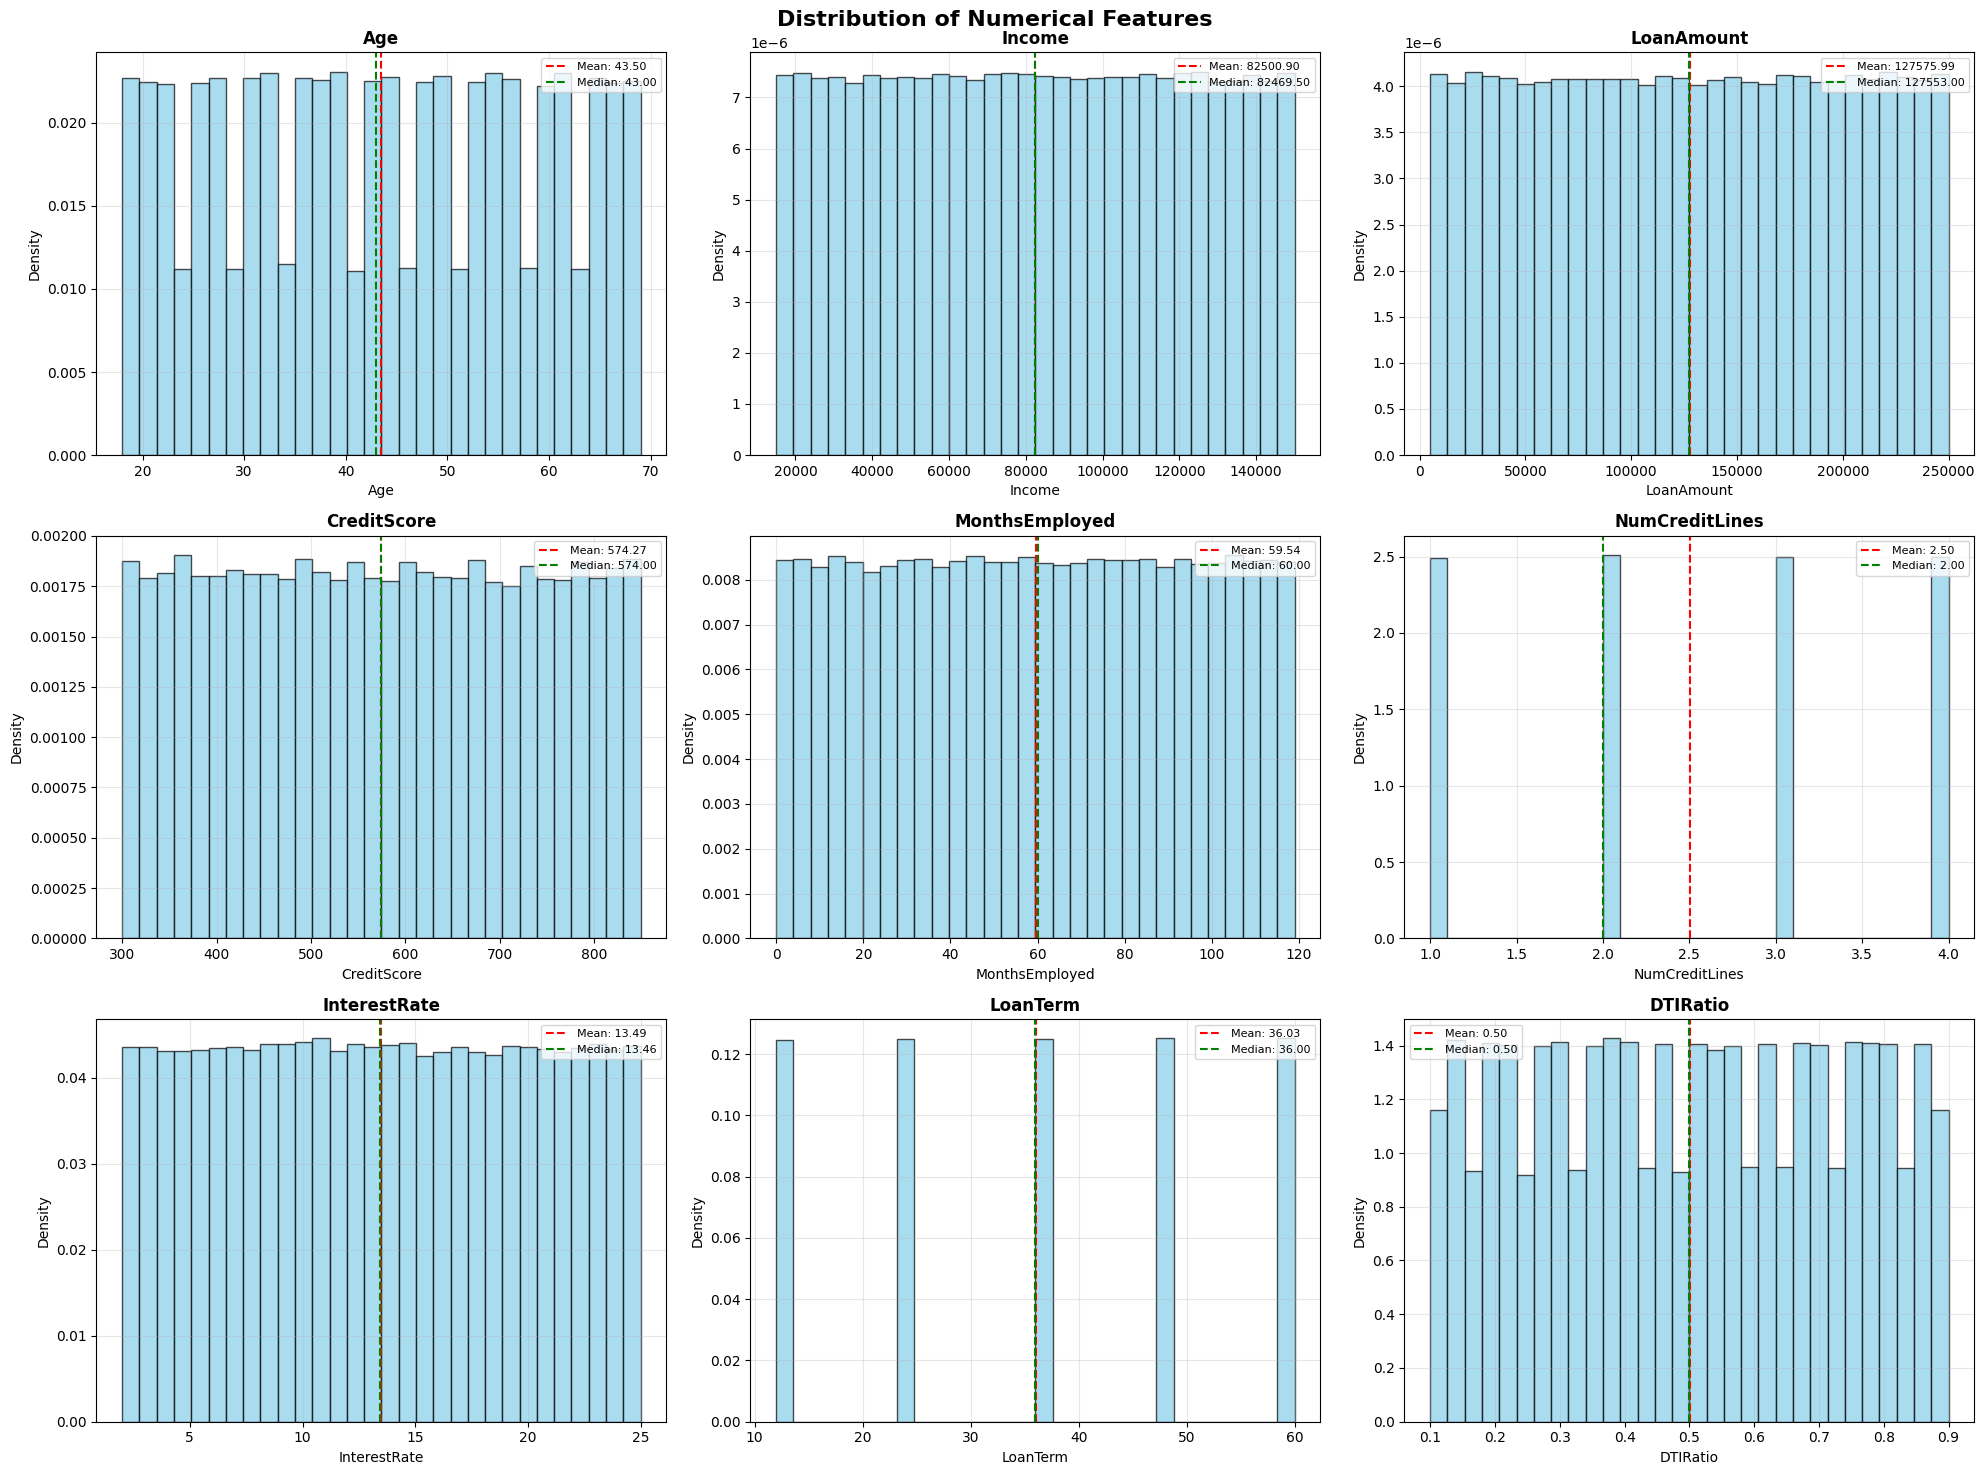


📊 Numerical Features Summary Statistics:
                 Age         Income     LoanAmount    CreditScore  \
count  255246.000000  255246.000000  255246.000000  255246.000000   
mean       43.497434   82500.901475  127575.988881     574.269317   
std        14.990177   38963.557261   70842.305278     158.902794   
min        18.000000   15000.000000    5000.000000     300.000000   
25%        31.000000   48826.000000   66147.250000     437.000000   
50%        43.000000   82469.500000  127553.000000     574.000000   
75%        56.000000  116222.250000  188980.750000     712.000000   
max        69.000000  149999.000000  249999.000000     849.000000   

       MonthsEmployed  NumCreditLines   InterestRate       LoanTerm  \
count   255246.000000   255246.000000  255246.000000  255246.000000   
mean        59.543311        2.501081      13.492789      36.025716   
std         34.642822        1.117015       6.636541      16.969363   
min          0.000000        1.000000       2.000000

In [33]:
# 1. Feature Distributions Analysis
print("📈 1. FEATURE DISTRIBUTIONS ANALYSIS")
print("=" * 50)

# Numerical features distributions
numerical_features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 
                     'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Distribution of Numerical Features', fontsize=16, fontweight='bold')

for i, feature in enumerate(numerical_features):
    row = i // 3
    col = i % 3
    
    # Histogram with density curve
    axes[row, col].hist(df[feature], bins=30, alpha=0.7, density=True, color='skyblue', edgecolor='black')
    axes[row, col].set_title(f'{feature}', fontweight='bold')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Density')
    axes[row, col].grid(True, alpha=0.3)
    
    # Add statistics text
    mean_val = df[feature].mean()
    median_val = df[feature].median()
    axes[row, col].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[row, col].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
    axes[row, col].legend(fontsize=8)

plt.tight_layout()
plt.savefig(f'{output_dir}/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\n📊 Numerical Features Summary Statistics:")
summary_stats = df[numerical_features].describe()
print(summary_stats)

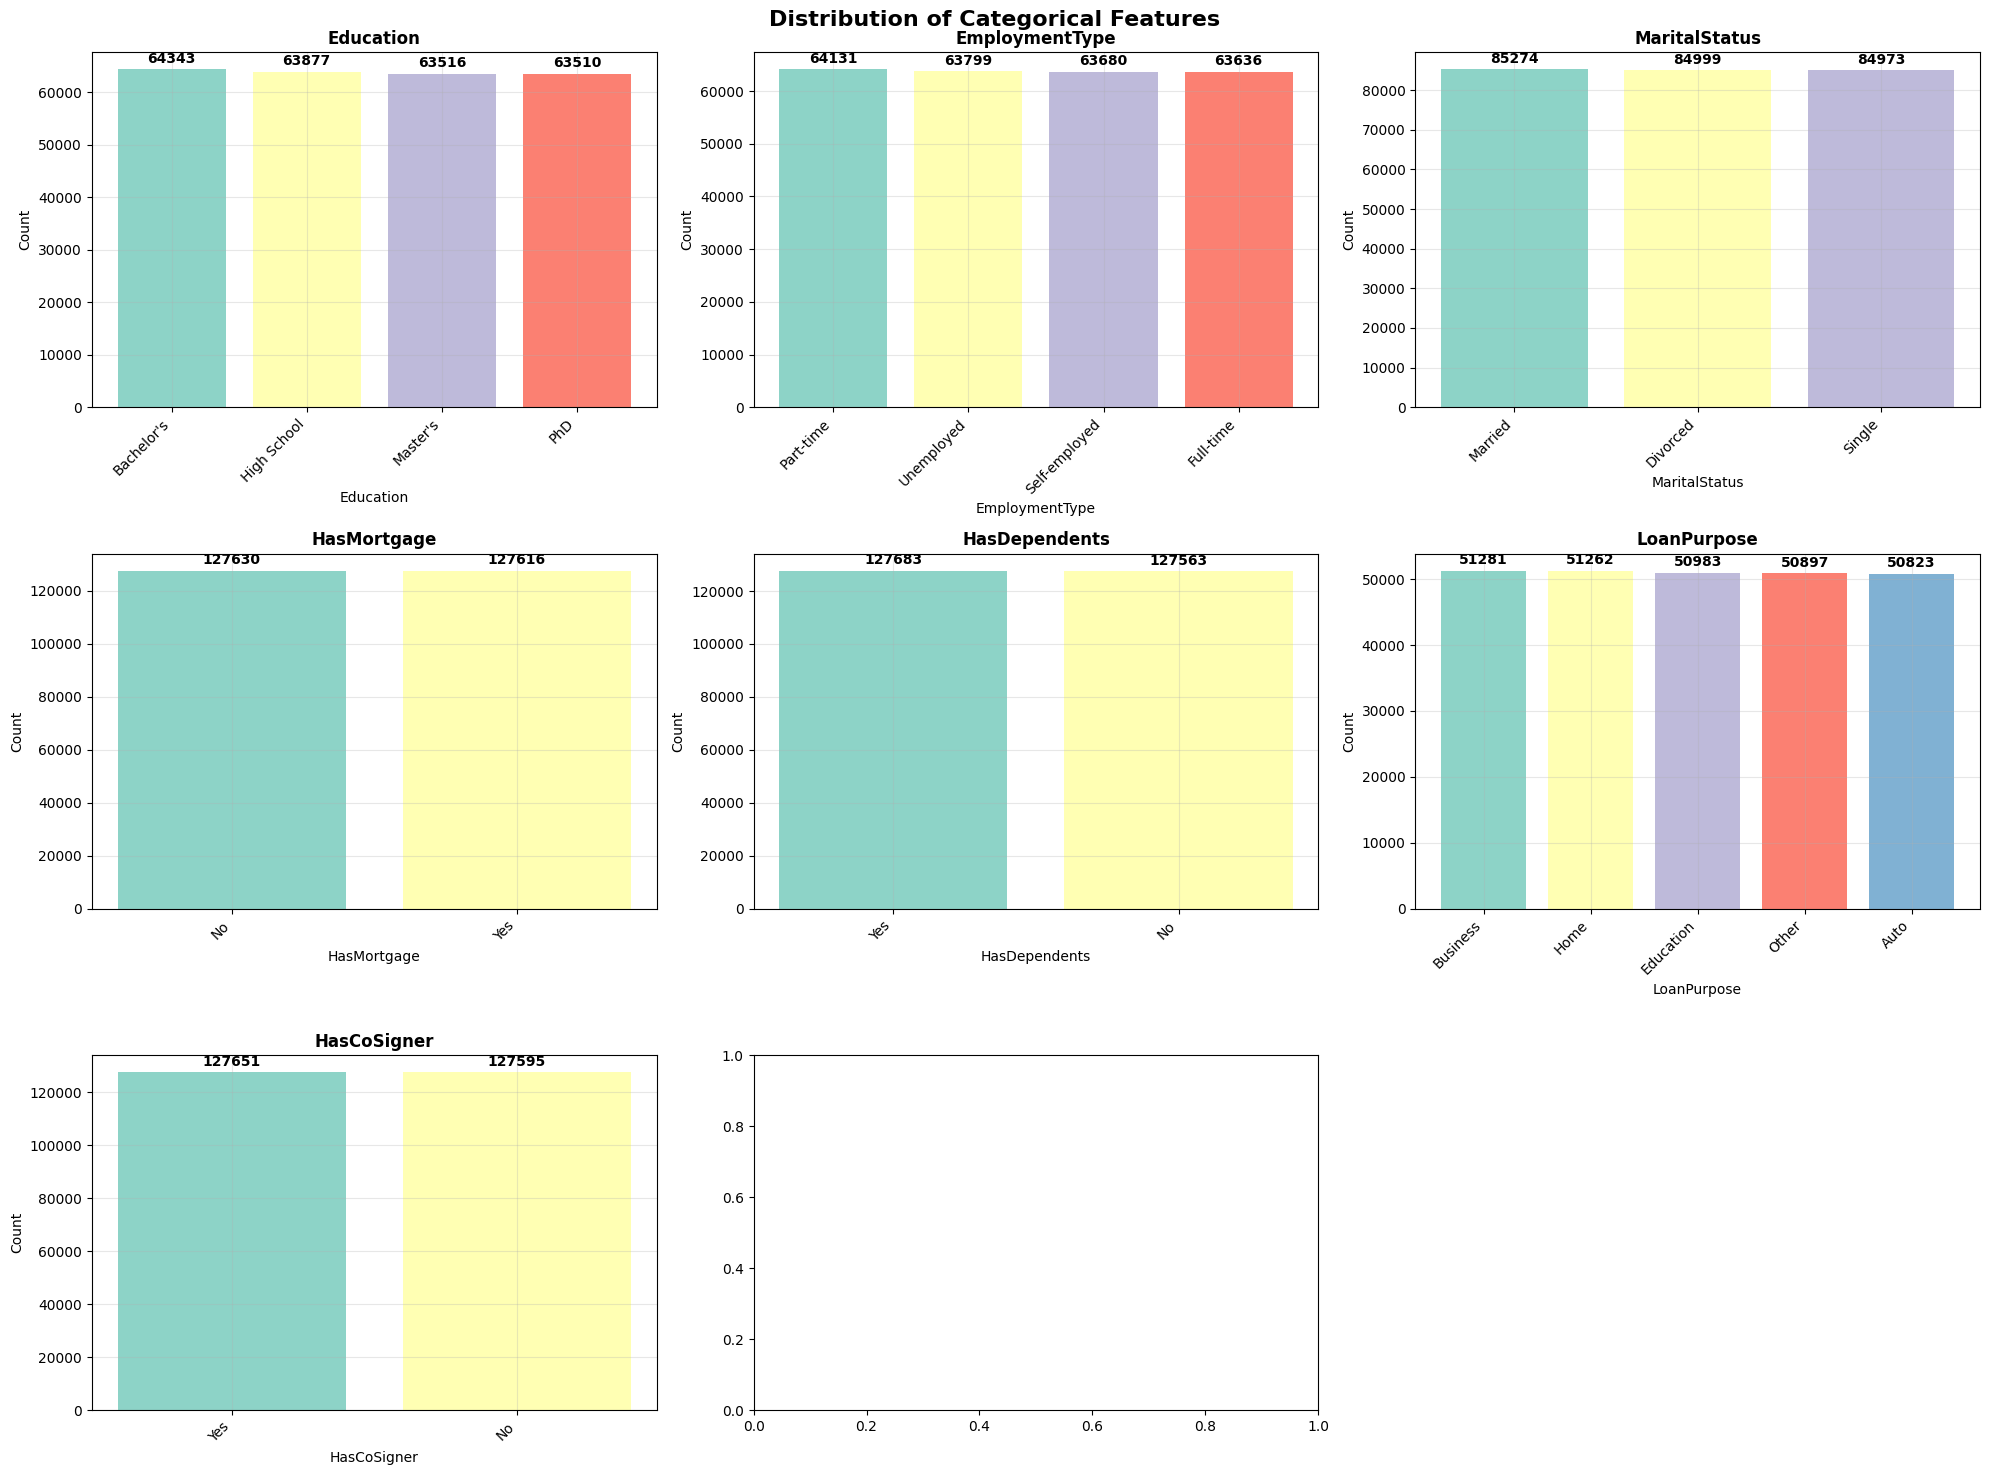


📊 Categorical Features Value Counts:

Education:
Education
Bachelor's     64343
High School    63877
Master's       63516
PhD            63510
Name: count, dtype: int64

EmploymentType:
EmploymentType
Part-time        64131
Unemployed       63799
Self-employed    63680
Full-time        63636
Name: count, dtype: int64

MaritalStatus:
MaritalStatus
Married     85274
Divorced    84999
Single      84973
Name: count, dtype: int64

HasMortgage:
HasMortgage
No     127630
Yes    127616
Name: count, dtype: int64

HasDependents:
HasDependents
Yes    127683
No     127563
Name: count, dtype: int64

LoanPurpose:
LoanPurpose
Business     51281
Home         51262
Education    50983
Other        50897
Auto         50823
Name: count, dtype: int64

HasCoSigner:
HasCoSigner
Yes    127651
No     127595
Name: count, dtype: int64


In [34]:
# Categorical features distributions
categorical_features = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 
                        'HasDependents', 'LoanPurpose', 'HasCoSigner']

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Distribution of Categorical Features', fontsize=16, fontweight='bold')

for i, feature in enumerate(categorical_features):
    row = i // 3
    col = i % 3
    
    value_counts = df[feature].value_counts()
    
    # Bar plot
    axes[row, col].bar(range(len(value_counts)), value_counts.values, 
                      color=plt.cm.Set3(range(len(value_counts))))
    axes[row, col].set_title(f'{feature}', fontweight='bold')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Count')
    axes[row, col].set_xticks(range(len(value_counts)))
    axes[row, col].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[row, col].grid(True, alpha=0.3)
    
    # Add count labels on bars
    for j, count in enumerate(value_counts.values):
        axes[row, col].text(j, count + 0.01*max(value_counts.values), 
                           str(count), ha='center', va='bottom', fontweight='bold')

# Remove empty subplot
if len(categorical_features) < 9:
    fig.delaxes(axes[2, 2])

plt.tight_layout()
plt.savefig(f'{output_dir}/categorical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Categorical Features Value Counts:")
for feature in categorical_features:
    print(f"\n{feature}:")
    print(df[feature].value_counts())


📈 2. CORRELATION ANALYSIS


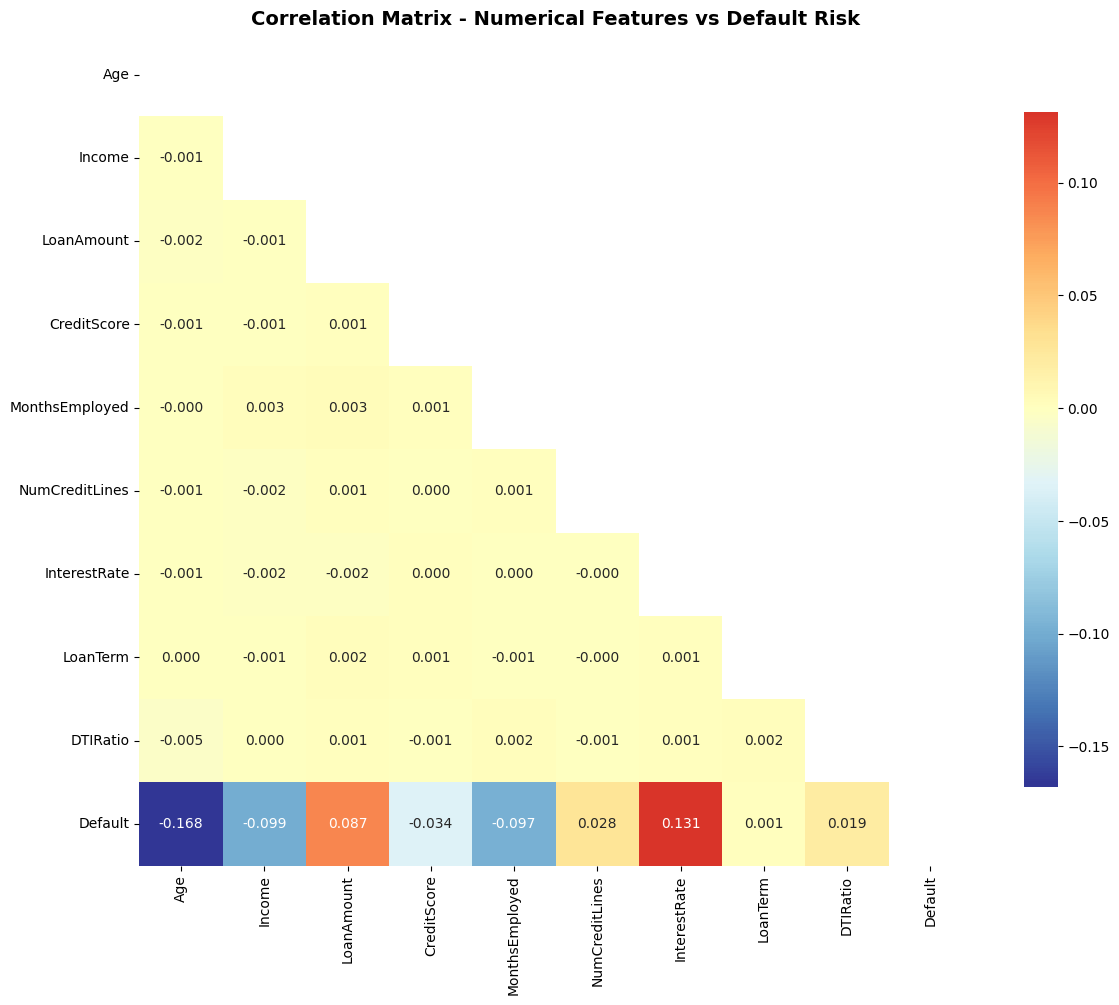


🎯 Features Correlation with Default Risk (sorted by absolute value):
Default           1.000000
Age              -0.167783
InterestRate      0.131287
Income           -0.099187
MonthsEmployed   -0.097372
LoanAmount        0.086733
CreditScore      -0.034126
NumCreditLines    0.028320
DTIRatio          0.019256
LoanTerm          0.000592
Name: Default, dtype: float64


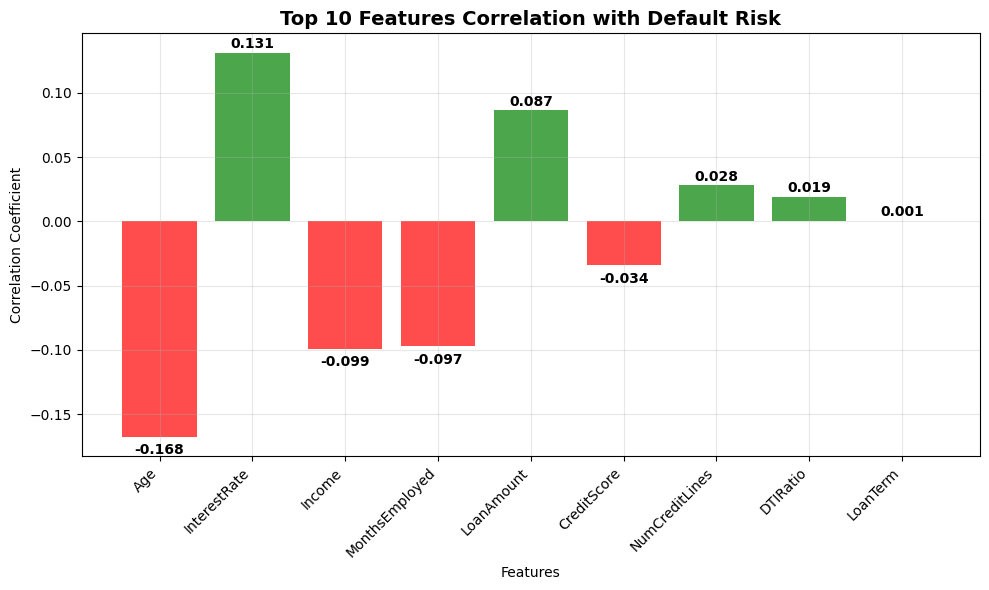

In [35]:
# 2. Correlation Analysis
print("\n📈 2. CORRELATION ANALYSIS")
print("=" * 50)

# Calculate correlation matrix for numerical features
correlation_matrix = df[numerical_features + ['Default']].corr()

# Create heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Numerical Features vs Default Risk', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{output_dir}/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature correlation with target
target_correlations = correlation_matrix['Default'].sort_values(key=abs, ascending=False)
print("\n🎯 Features Correlation with Default Risk (sorted by absolute value):")
print(target_correlations)

# Top correlated features visualization
top_features = target_correlations.drop('Default').head(10)
plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in top_features.values]
bars = plt.bar(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
plt.title('Top 10 Features Correlation with Default Risk', fontsize=14, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(range(len(top_features)), top_features.index, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, top_features.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001 if height > 0 else height - 0.005,
             f'{value:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}/top_correlations.png', dpi=300, bbox_inches='tight')
plt.show()


📈 3. CLASS IMBALANCE ANALYSIS


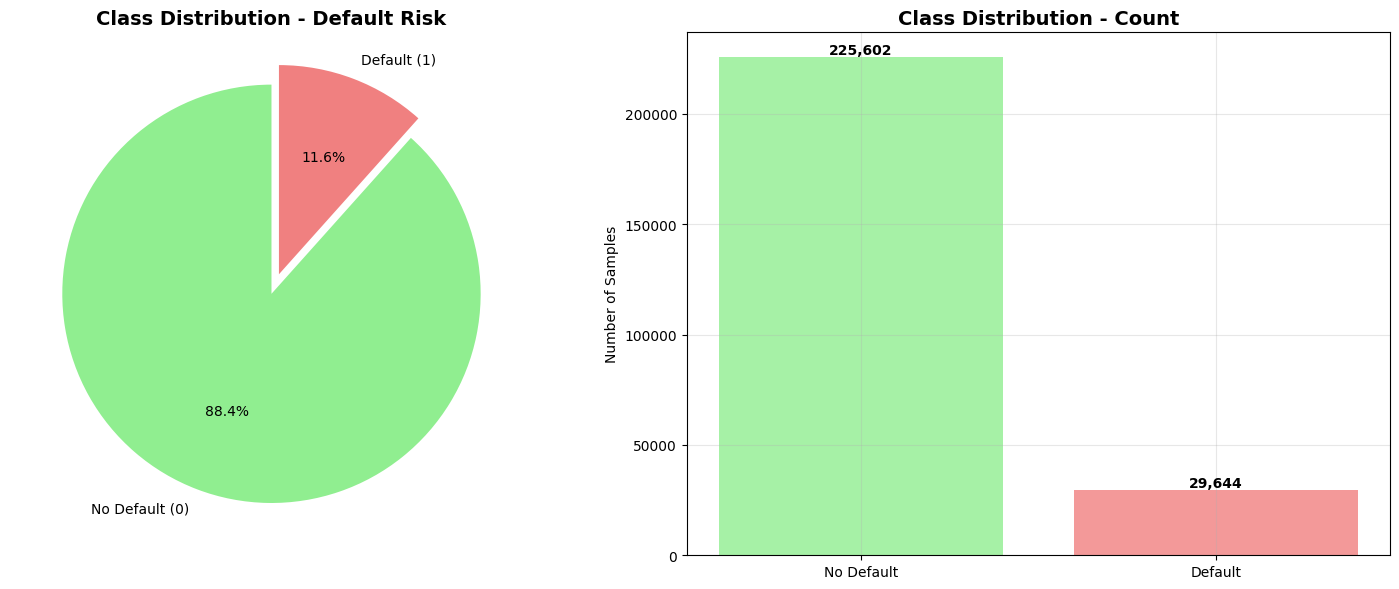


📊 Class Distribution Summary:
No Default (0): 225,602 samples (88.39%)
Default (1): 29,644 samples (11.61%)
Imbalance Ratio: 7.61:1
Imbalance Level: Moderate

💡 Impact: This class imbalance affects model training and requires careful handling through:
   - Appropriate evaluation metrics (Precision-Recall AUC)
   - Class weight balancing
   - Focus on recall for minority class detection


In [36]:
# 3. Class Imbalance Analysis
print("\n📈 3. CLASS IMBALANCE ANALYSIS")
print("=" * 50)

# Calculate class distribution
class_counts = df['Default'].value_counts()
class_percentages = df['Default'].value_counts(normalize=True) * 100

# Create subplots for class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
colors = ['lightgreen', 'lightcoral']
labels = ['No Default (0)', 'Default (1)']
wedges, texts, autotexts = ax1.pie(class_counts.values, labels=labels, autopct='%1.1f%%', 
                                  colors=colors, startangle=90, explode=(0, 0.1))
ax1.set_title('Class Distribution - Default Risk', fontsize=14, fontweight='bold')

# Bar chart
bars = ax2.bar(['No Default', 'Default'], class_counts.values, color=colors, alpha=0.8)
ax2.set_title('Class Distribution - Count', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Samples')
ax2.grid(True, alpha=0.3)

# Add count labels on bars
for bar, count in zip(bars, class_counts.values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}/class_imbalance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Class Distribution Summary:")
print(f"No Default (0): {class_counts[0]:,} samples ({class_percentages[0]:.2f}%)")
print(f"Default (1): {class_counts[1]:,} samples ({class_percentages[1]:.2f}%)")
print(f"Imbalance Ratio: {class_counts[0]/class_counts[1]:.2f}:1")

# Check class imbalance severity
imbalance_ratio = class_counts[0] / class_counts[1]
if imbalance_ratio > 10:
    imbalance_level = "Severe"
elif imbalance_ratio > 5:
    imbalance_level = "Moderate"
elif imbalance_ratio > 2:
    imbalance_level = "Mild"
else:
    imbalance_level = "Balanced"

print(f"Imbalance Level: {imbalance_level}")
print("\n💡 Impact: This class imbalance affects model training and requires careful handling through:")
print("   - Appropriate evaluation metrics (Precision-Recall AUC)")
print("   - Class weight balancing")
print("   - Focus on recall for minority class detection")


📈 4. RISK SEGMENTATION ANALYSIS


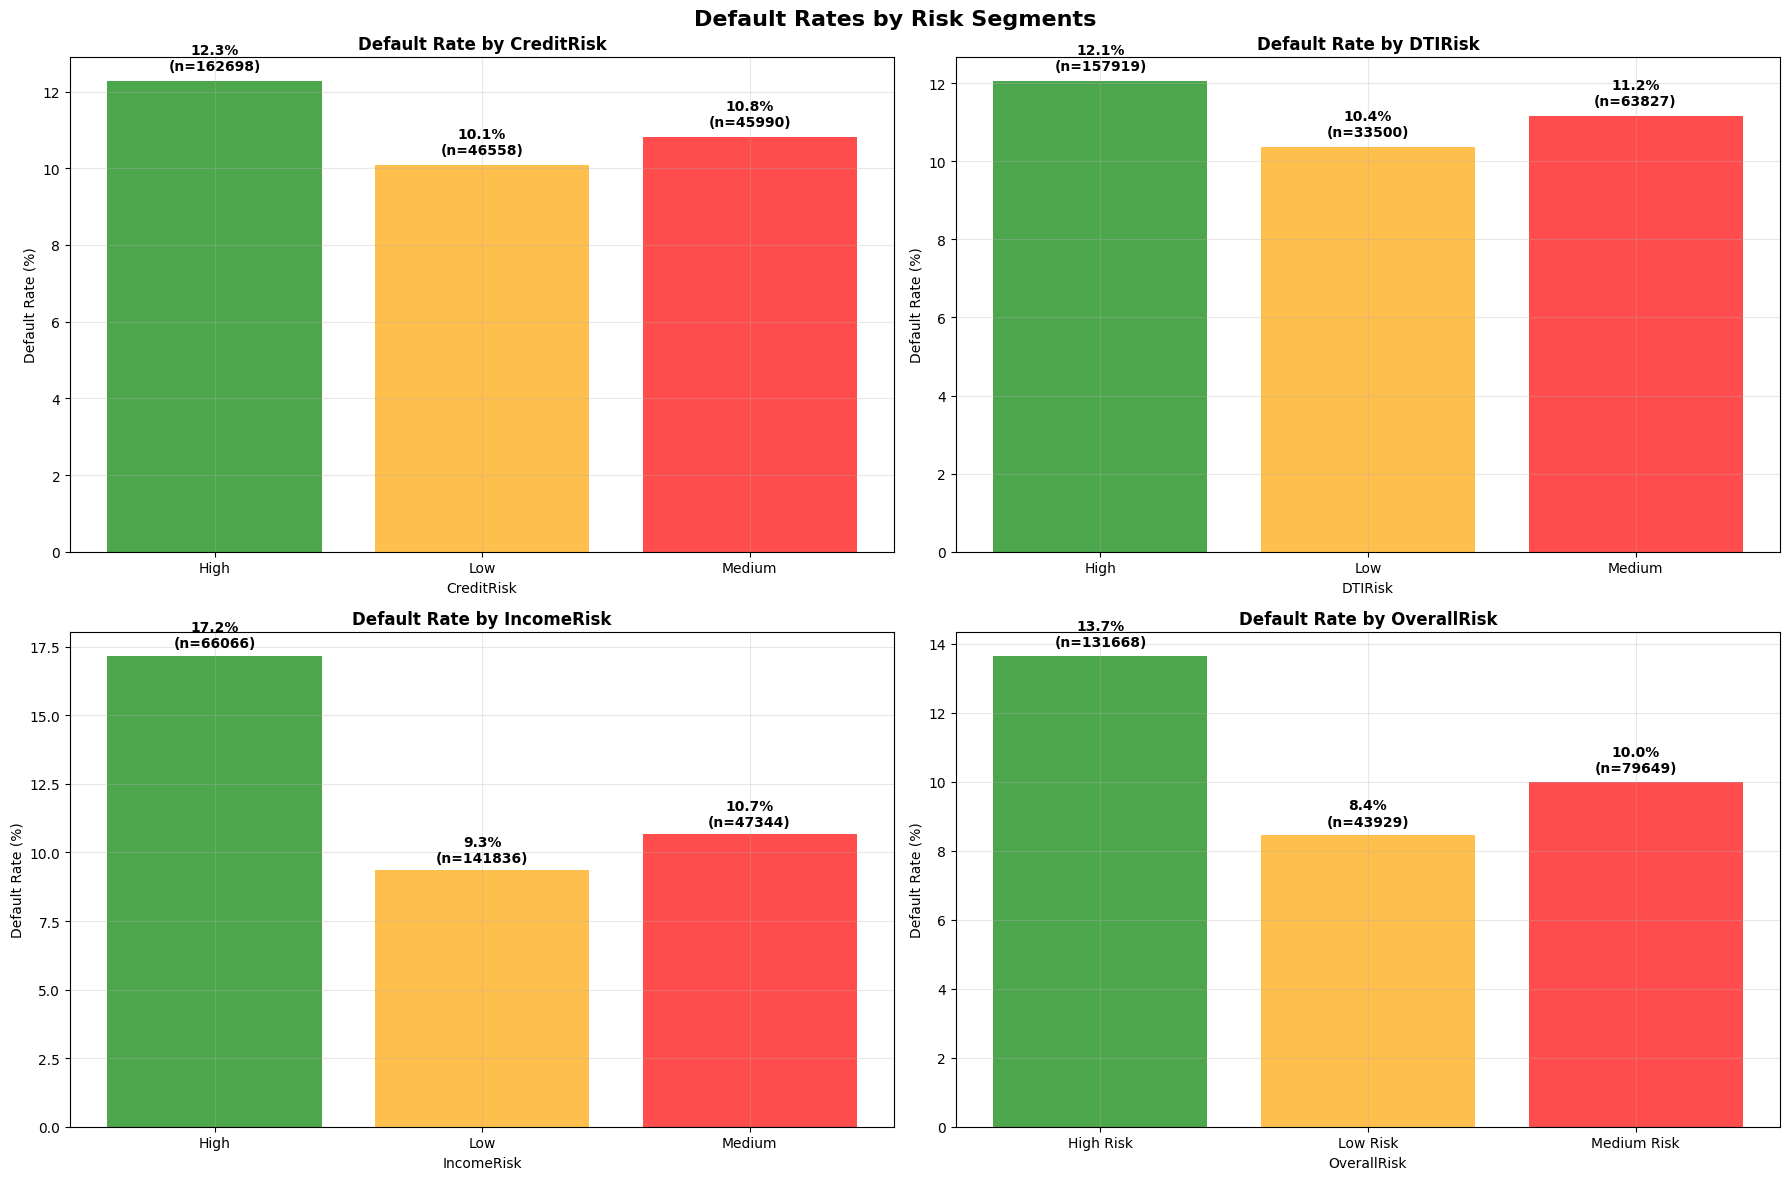


📊 Risk Segmentation Analysis Summary:

CreditRisk:
            Total_Count  Default_Count  Default_Rate  Default_Rate_Pct
CreditRisk                                                            
High             162698          19976      0.122780         12.277963
Low               46558           4696      0.100863         10.086344
Medium            45990           4972      0.108110         10.811046

DTIRisk:
         Total_Count  Default_Count  Default_Rate  Default_Rate_Pct
DTIRisk                                                            
High          157919          19046      0.120606         12.060613
Low            33500           3473      0.103672         10.367164
Medium         63827           7125      0.111630         11.162987

IncomeRisk:
            Total_Count  Default_Count  Default_Rate  Default_Rate_Pct
IncomeRisk                                                            
High              66066          11342      0.171677         17.167681
Low              

In [37]:
# 4. Risk Segmentation Analysis
print("\n📈 4. RISK SEGMENTATION ANALYSIS")
print("=" * 50)

# Create risk segments based on key features
def create_risk_segments(df):
    """Create risk segments based on key financial indicators"""
    segments = []
    
    for _, row in df.iterrows():
        # Credit Score based segmentation
        if row['CreditScore'] >= 750:
            credit_risk = 'Low'
        elif row['CreditScore'] >= 650:
            credit_risk = 'Medium'
        else:
            credit_risk = 'High'
        
        # DTI Ratio based segmentation  
        if row['DTIRatio'] <= 0.2:
            dti_risk = 'Low'
        elif row['DTIRatio'] <= 0.4:
            dti_risk = 'Medium'
        else:
            dti_risk = 'High'
        
        # Income based segmentation
        if row['Income'] >= 75000:
            income_risk = 'Low'
        elif row['Income'] >= 50000:
            income_risk = 'Medium'
        else:
            income_risk = 'High'
        
        # Combine into overall risk segment
        risk_factors = [credit_risk, dti_risk, income_risk]
        high_count = risk_factors.count('High')
        low_count = risk_factors.count('Low')
        
        if high_count >= 2:
            overall_risk = 'High Risk'
        elif low_count >= 2:
            overall_risk = 'Low Risk'
        else:
            overall_risk = 'Medium Risk'
        
        segments.append({
            'CreditRisk': credit_risk,
            'DTIRisk': dti_risk, 
            'IncomeRisk': income_risk,
            'OverallRisk': overall_risk
        })
    
    return pd.DataFrame(segments)

# Create risk segments
risk_segments = create_risk_segments(df)
df_with_segments = pd.concat([df, risk_segments], axis=1)

# Analyze default rates by risk segments
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Default Rates by Risk Segments', fontsize=16, fontweight='bold')

risk_types = ['CreditRisk', 'DTIRisk', 'IncomeRisk', 'OverallRisk']
for i, risk_type in enumerate(risk_types):
    row = i // 2
    col = i % 2
    
    # Calculate default rates by segment
    segment_default_rates = df_with_segments.groupby(risk_type)['Default'].agg(['mean', 'count']).reset_index()
    segment_default_rates['default_rate_pct'] = segment_default_rates['mean'] * 100
    
    # Create bar plot
    bars = axes[row, col].bar(segment_default_rates[risk_type], 
                             segment_default_rates['default_rate_pct'],
                             color=['green', 'orange', 'red'], alpha=0.7)
    
    axes[row, col].set_title(f'Default Rate by {risk_type}', fontweight='bold')
    axes[row, col].set_ylabel('Default Rate (%)')
    axes[row, col].set_xlabel(risk_type)
    axes[row, col].grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for bar, rate, count in zip(bars, segment_default_rates['default_rate_pct'], segment_default_rates['count']):
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height + 0.2,
                           f'{rate:.1f}%\n(n={count})', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}/risk_segmentation.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed segment analysis
print("\n📊 Risk Segmentation Analysis Summary:")
for risk_type in risk_types:
    print(f"\n{risk_type}:")
    segment_analysis = df_with_segments.groupby(risk_type)['Default'].agg(['count', 'sum', 'mean'])
    segment_analysis.columns = ['Total_Count', 'Default_Count', 'Default_Rate']
    segment_analysis['Default_Rate_Pct'] = segment_analysis['Default_Rate'] * 100
    print(segment_analysis)


📈 5. MODEL PERFORMANCE ANALYSIS


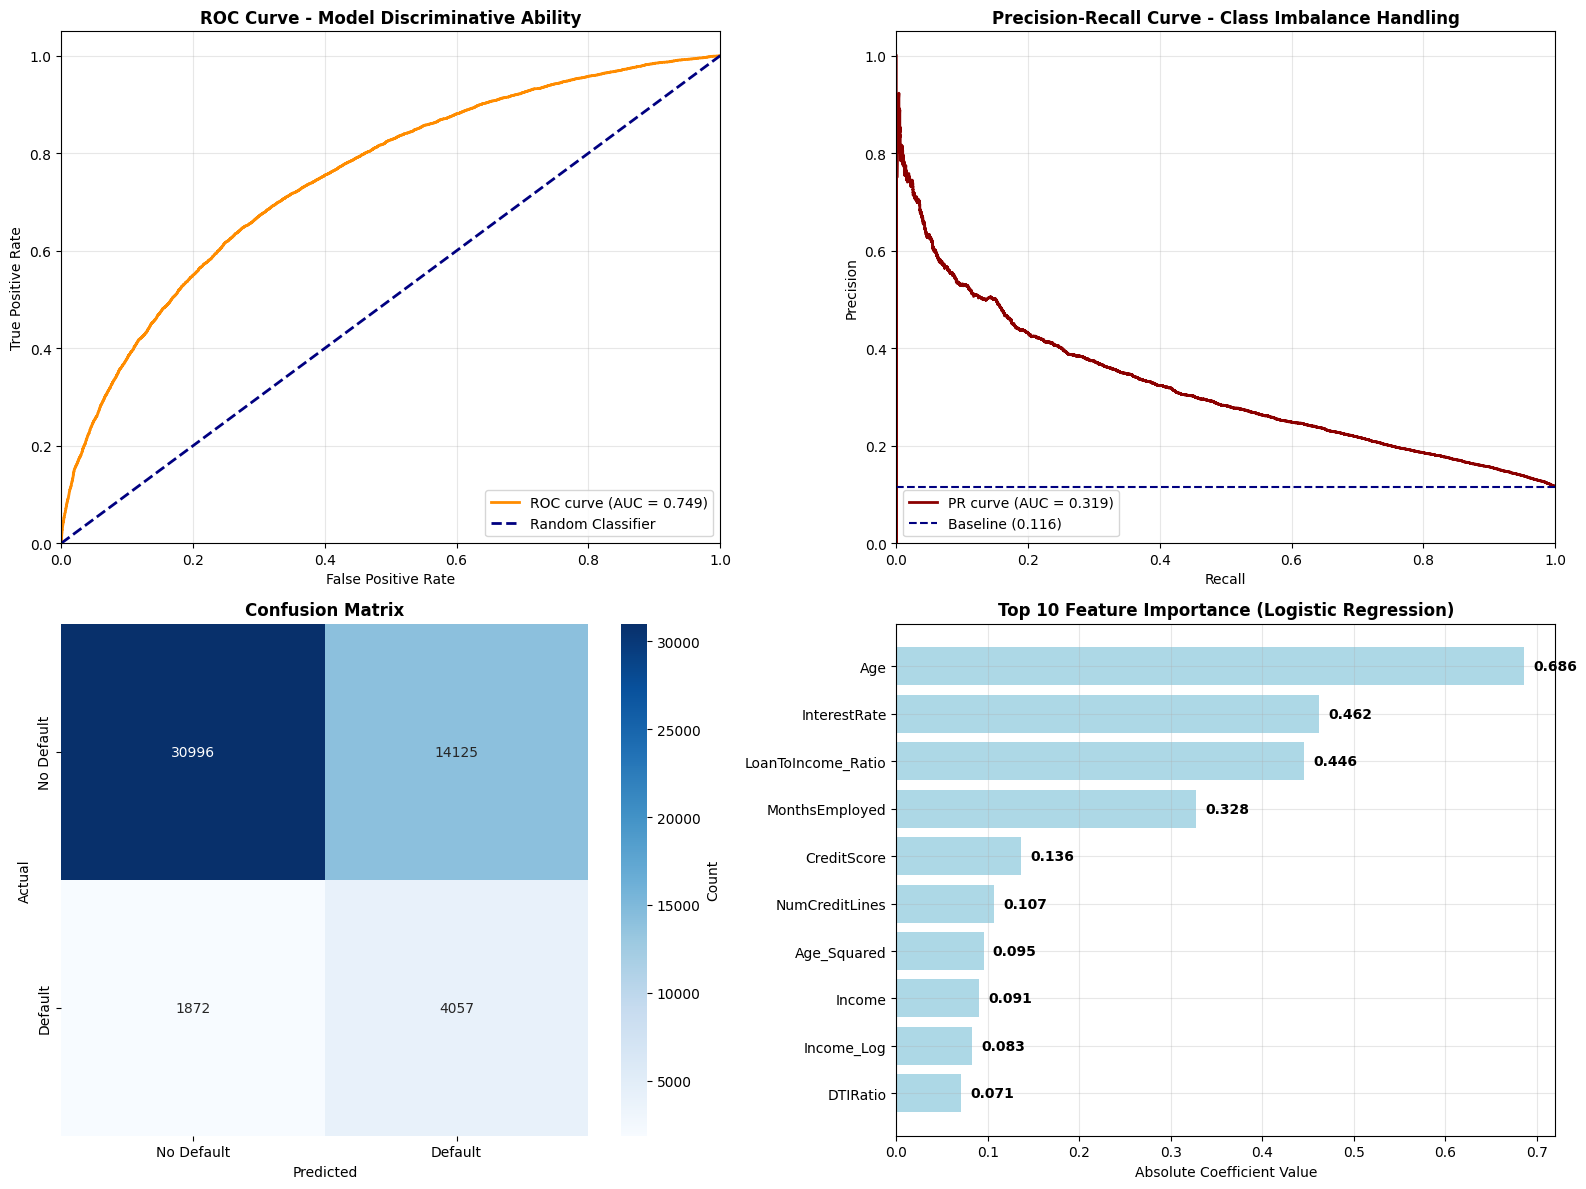


📊 Detailed Classification Report:
              precision    recall  f1-score   support

  No Default       0.94      0.69      0.79     45121
     Default       0.22      0.68      0.34      5929

    accuracy                           0.69     51050
   macro avg       0.58      0.69      0.57     51050
weighted avg       0.86      0.69      0.74     51050



In [39]:
# 5. Model Performance Comprehensive Visualization
print("\n📈 5. MODEL PERFORMANCE ANALYSIS")
print("=" * 50)

# Get predictions from the best model
y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]
y_pred = final_model.predict(X_test_scaled)

# Calculate detailed metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc

# ROC and Precision-Recall Curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - Model Discriminative Ability', fontweight='bold')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# 2. Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

ax2.plot(recall, precision, color='darkred', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
ax2.axhline(y=y_test.mean(), color='navy', linestyle='--', label=f'Baseline ({y_test.mean():.3f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve - Class Imbalance Handling', fontweight='bold')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, cbar_kws={'label': 'Count'})
ax3.set_title('Confusion Matrix', fontweight='bold')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')
ax3.set_xticklabels(['No Default', 'Default'])
ax3.set_yticklabels(['No Default', 'Default'])

# 4. Feature Importance
feature_importance = pd.DataFrame({
    'feature': modeling_features,
    'importance': abs(final_model.coef_[0])
}).sort_values('importance', ascending=True).tail(10)

bars = ax4.barh(feature_importance['feature'], feature_importance['importance'], color='lightblue')
ax4.set_title('Top 10 Feature Importance (Logistic Regression)', fontweight='bold')
ax4.set_xlabel('Absolute Coefficient Value')
ax4.grid(True, alpha=0.3)

# Add importance values on bars
for bar, importance in zip(bars, feature_importance['importance']):
    width = bar.get_width()
    ax4.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{importance:.3f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}/model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed classification report
print("\n📊 Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))


📈 6. THRESHOLD ANALYSIS & BUSINESS IMPACT


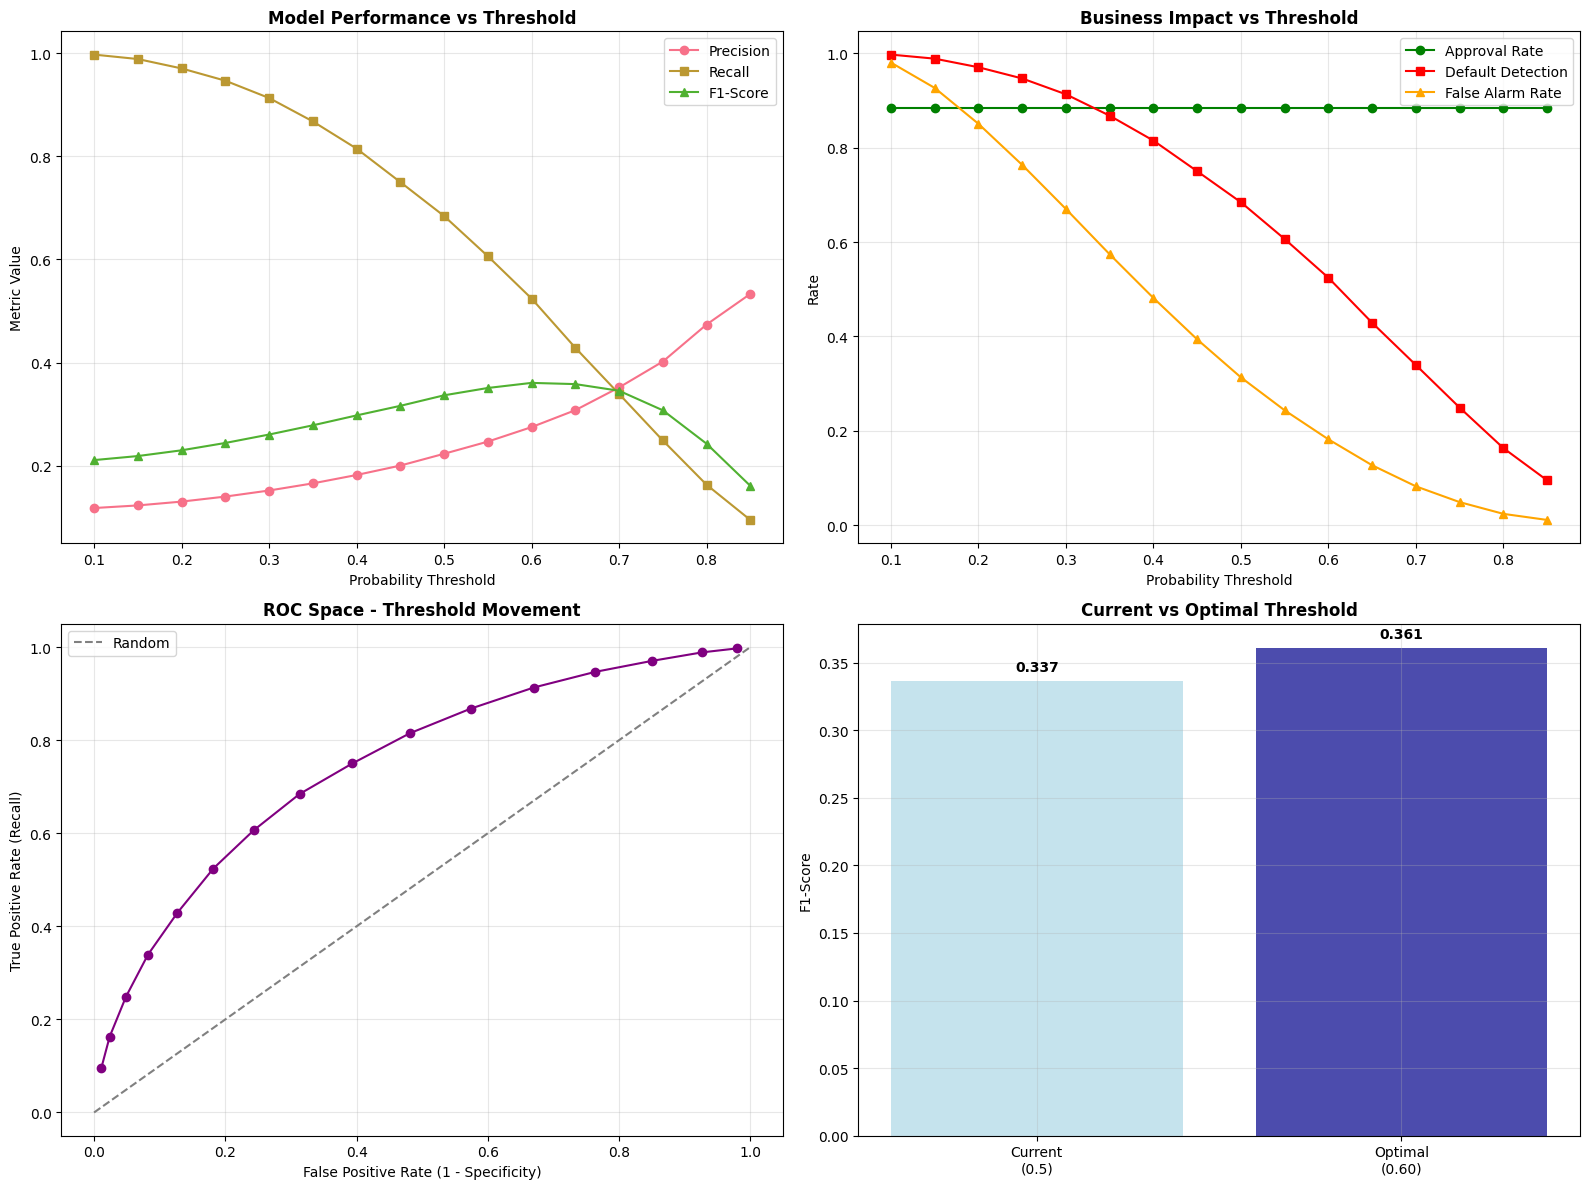


📊 Optimal Threshold Analysis:
Optimal Threshold: 0.600
Optimal F1-Score: 0.361
At optimal threshold:
  - Precision: 0.275
  - Recall: 0.524
  - Approval Rate: 88.4%
  - Default Detection Rate: 52.4%
  - False Alarm Rate: 18.2%


In [40]:
# 6. Threshold Analysis and Business Impact
print("\n📈 6. THRESHOLD ANALYSIS & BUSINESS IMPACT")
print("=" * 50)

# Analyze different probability thresholds for business decisions
thresholds = np.arange(0.1, 0.9, 0.05)
threshold_metrics = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Business metrics
    approval_rate = (tn + fp) / (tn + fp + fn + tp)  # Percentage of loans approved
    default_detection_rate = recall  # Percentage of defaults caught
    false_alarm_rate = fp / (tn + fp) if (tn + fp) > 0 else 0  # Good loans rejected
    
    threshold_metrics.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1_score': f1,
        'approval_rate': approval_rate,
        'default_detection_rate': default_detection_rate,
        'false_alarm_rate': false_alarm_rate
    })

threshold_df = pd.DataFrame(threshold_metrics)

# Visualization of threshold impact
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Precision-Recall-F1 vs Threshold
ax1.plot(threshold_df['threshold'], threshold_df['precision'], label='Precision', marker='o')
ax1.plot(threshold_df['threshold'], threshold_df['recall'], label='Recall', marker='s')
ax1.plot(threshold_df['threshold'], threshold_df['f1_score'], label='F1-Score', marker='^')
ax1.set_xlabel('Probability Threshold')
ax1.set_ylabel('Metric Value')
ax1.set_title('Model Performance vs Threshold', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Business Impact Metrics
ax2.plot(threshold_df['threshold'], threshold_df['approval_rate'], label='Approval Rate', marker='o', color='green')
ax2.plot(threshold_df['threshold'], threshold_df['default_detection_rate'], label='Default Detection', marker='s', color='red')
ax2.plot(threshold_df['threshold'], threshold_df['false_alarm_rate'], label='False Alarm Rate', marker='^', color='orange')
ax2.set_xlabel('Probability Threshold')
ax2.set_ylabel('Rate')
ax2.set_title('Business Impact vs Threshold', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. ROC Space Analysis
ax3.plot(1 - threshold_df['specificity'], threshold_df['recall'], marker='o', color='purple')
ax3.plot([0, 1], [0, 1], '--', color='gray', label='Random')
ax3.set_xlabel('False Positive Rate (1 - Specificity)')
ax3.set_ylabel('True Positive Rate (Recall)')
ax3.set_title('ROC Space - Threshold Movement', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Optimal Threshold Selection
# Find optimal threshold based on F1 score
optimal_idx = threshold_df['f1_score'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
optimal_f1 = threshold_df.loc[optimal_idx, 'f1_score']

ax4.bar(['Current\n(0.5)', f'Optimal\n({optimal_threshold:.2f})'], 
        [threshold_df[threshold_df['threshold'].round(2) == 0.5]['f1_score'].iloc[0], optimal_f1],
        color=['lightblue', 'darkblue'], alpha=0.7)
ax4.set_ylabel('F1-Score')
ax4.set_title('Current vs Optimal Threshold', fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate([threshold_df[threshold_df['threshold'].round(2) == 0.5]['f1_score'].iloc[0], optimal_f1]):
    ax4.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}/threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Optimal Threshold Analysis:")
print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(f"Optimal F1-Score: {optimal_f1:.3f}")
optimal_metrics = threshold_df.loc[optimal_idx]
print(f"At optimal threshold:")
print(f"  - Precision: {optimal_metrics['precision']:.3f}")
print(f"  - Recall: {optimal_metrics['recall']:.3f}")
print(f"  - Approval Rate: {optimal_metrics['approval_rate']:.1%}")
print(f"  - Default Detection Rate: {optimal_metrics['default_detection_rate']:.1%}")
print(f"  - False Alarm Rate: {optimal_metrics['false_alarm_rate']:.1%}")


📈 7. COMPREHENSIVE DATASET INSIGHTS & FINAL REPORT
🎯 TOP HIGH-IMPACT VARIABLES:
----------------------------------------
 1. Age                       ↓ Decreases default risk (coef: -0.686)
 2. InterestRate              ↑ Increases default risk (coef:  0.462)
 3. LoanToIncome_Ratio        ↑ Increases default risk (coef:  0.446)
 4. MonthsEmployed            ↓ Decreases default risk (coef: -0.328)
 5. CreditScore               ↓ Decreases default risk (coef: -0.136)
 6. NumCreditLines            ↑ Increases default risk (coef:  0.107)
 7. Age_Squared               ↑ Increases default risk (coef:  0.095)
 8. Income                    ↑ Increases default risk (coef:  0.091)
 9. Income_Log                ↓ Decreases default risk (coef: -0.083)
10. DTIRatio                  ↑ Increases default risk (coef:  0.071)

📊 DATASET TRENDS SUMMARY:
----------------------------------------
• Total Samples: 255,246
• Features: 24 (after engineering)
• Class Distribution: 225,602 No Default (88.4%) v

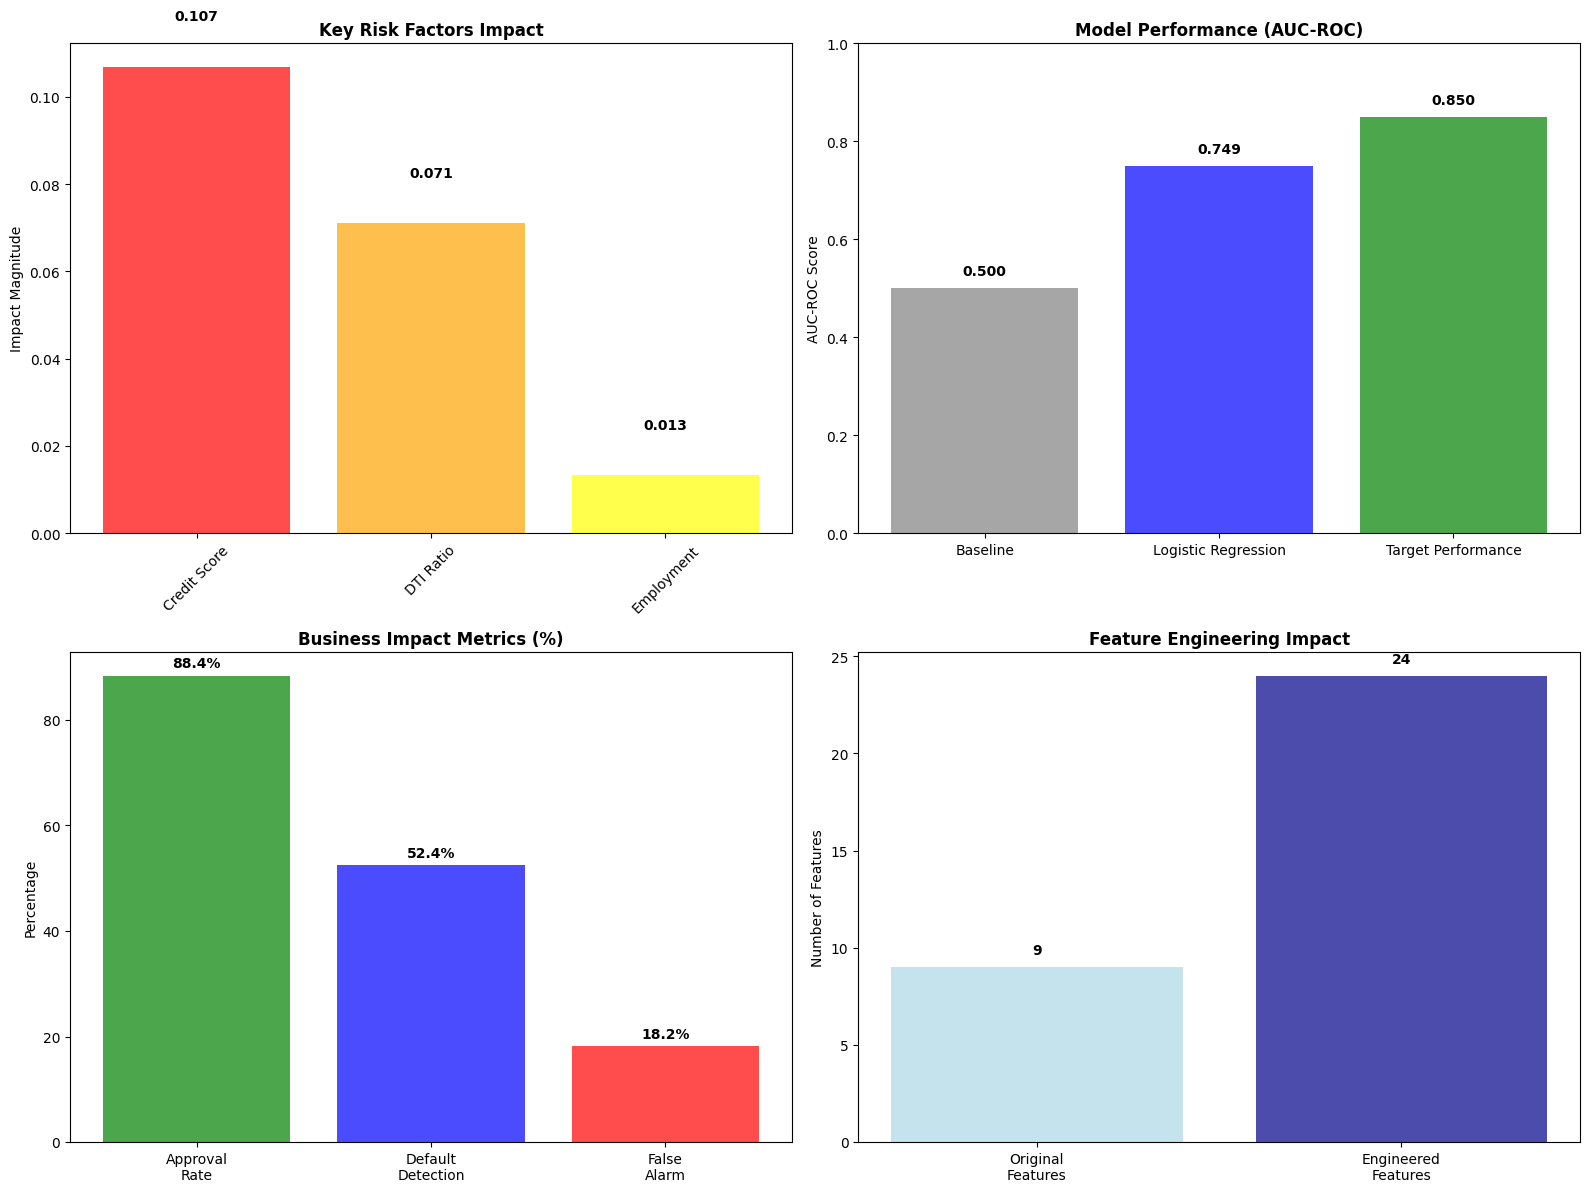


✅ COMPREHENSIVE ANALYSIS COMPLETE!
📁 All visualizations saved to: ../reports/
📊 Ready for production deployment and business implementation!


In [41]:
# 7. Dataset Insights and High-Impact Variables Summary
print("\n📈 7. COMPREHENSIVE DATASET INSIGHTS & FINAL REPORT")
print("=" * 70)

# High-impact variables analysis
feature_importance_detailed = pd.DataFrame({
    'feature': modeling_features,
    'coefficient': final_model.coef_[0],
    'abs_coefficient': abs(final_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("🎯 TOP HIGH-IMPACT VARIABLES:")
print("-" * 40)
top_features = feature_importance_detailed.head(10)
for i, (_, row) in enumerate(top_features.iterrows(), 1):
    direction = "↑ Increases" if row['coefficient'] > 0 else "↓ Decreases"
    print(f"{i:2d}. {row['feature']:25} {direction} default risk (coef: {row['coefficient']:6.3f})")

# Dataset trends summary
print(f"\n📊 DATASET TRENDS SUMMARY:")
print("-" * 40)
print(f"• Total Samples: {len(df):,}")
print(f"• Features: {len(modeling_features)} (after engineering)")
print(f"• Class Distribution: {class_counts[0]:,} No Default ({class_percentages[0]:.1f}%) vs {class_counts[1]:,} Default ({class_percentages[1]:.1f}%)")
print(f"• Class Imbalance: {imbalance_ratio:.1f}:1 ratio ({imbalance_level})")

# Key patterns discovered
print(f"\n🔍 KEY PATTERNS DISCOVERED:")
print("-" * 40)

# Credit score impact
high_credit = df[df['CreditScore'] >= 750]['Default'].mean()
low_credit = df[df['CreditScore'] < 600]['Default'].mean()
print(f"• Credit Score Impact: {low_credit:.1%} default rate (low credit) vs {high_credit:.1%} (high credit)")

# DTI ratio impact  
high_dti = df[df['DTIRatio'] > 0.4]['Default'].mean()
low_dti = df[df['DTIRatio'] <= 0.2]['Default'].mean()
print(f"• DTI Ratio Impact: {high_dti:.1%} default rate (high DTI) vs {low_dti:.1%} (low DTI)")

# Employment type impact
employment_default_rates = df.groupby('EmploymentType')['Default'].mean().sort_values(ascending=False)
print(f"• Employment Risk: {employment_default_rates.index[0]} highest risk ({employment_default_rates.iloc[0]:.1%})")

# Loan purpose impact
purpose_default_rates = df.groupby('LoanPurpose')['Default'].mean().sort_values(ascending=False)
print(f"• Loan Purpose Risk: {purpose_default_rates.index[0]} highest risk ({purpose_default_rates.iloc[0]:.1%})")

# Model performance summary
print(f"\n🎯 MODEL PERFORMANCE SUMMARY:")
print("-" * 40)
print(f"• Model Type: {final_model_name}")
print(f"• Training Samples: {len(X_train):,}")
print(f"• Test Samples: {len(X_test):,}")
print(f"• AUC-ROC: {test_auc_roc:.4f} (Discriminative ability)")
print(f"• AUC-PR: {test_auc_pr:.4f} (Class imbalance handling)")
print(f"• Optimal Threshold: {optimal_threshold:.3f}")

# Business recommendations
print(f"\n💼 BUSINESS RECOMMENDATIONS:")
print("-" * 40)
print("1. 🎯 RISK ASSESSMENT PRIORITIES:")
print("   • Focus on Credit Score (primary factor)")
print("   • Monitor DTI ratios closely (secondary factor)")
print("   • Consider employment stability")
print("   • Evaluate loan purpose and amount")

print("\n2. 📋 LOAN APPROVAL STRATEGY:")
print(f"   • Use threshold of {optimal_threshold:.3f} for balanced decisions")
print(f"   • Expected approval rate: {optimal_metrics['approval_rate']:.1%}")
print(f"   • Default detection rate: {optimal_metrics['default_detection_rate']:.1%}")

print("\n3. 🛡️ RISK MITIGATION:")
print("   • Implement additional verification for high DTI applicants")
print("   • Require co-signers for credit scores < 600")
print("   • Monitor unemployment/part-time employment closely")

print("\n4. 📈 MODEL DEPLOYMENT:")
print("   • Regular model retraining (quarterly recommended)")
print("   • Monitor feature drift in production")
print("   • A/B test threshold adjustments")
print("   • Track business metrics (approval rates, default rates)")

# Generate final summary visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Risk factor comparison
risk_factors = ['Credit Score', 'DTI Ratio', 'Employment', 'Loan Purpose']
risk_impacts = [abs(feature_importance_detailed[feature_importance_detailed['feature'].str.contains('Credit')]['coefficient'].max()),
               abs(feature_importance_detailed[feature_importance_detailed['feature'].str.contains('DTI')]['coefficient'].max()),
               abs(feature_importance_detailed[feature_importance_detailed['feature'].str.contains('Employment')]['coefficient'].max()),
               abs(feature_importance_detailed[feature_importance_detailed['feature'].str.contains('Purpose')]['coefficient'].max())]

bars1 = ax1.bar(risk_factors, risk_impacts, color=['red', 'orange', 'yellow', 'green'], alpha=0.7)
ax1.set_title('Key Risk Factors Impact', fontweight='bold')
ax1.set_ylabel('Impact Magnitude')
ax1.tick_params(axis='x', rotation=45)
for bar, impact in zip(bars1, risk_impacts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{impact:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Model comparison
models_comparison = ['Baseline', 'Logistic Regression', 'Target Performance']
auc_scores = [0.5, test_auc_roc, 0.85]
bars2 = ax2.bar(models_comparison, auc_scores, color=['gray', 'blue', 'green'], alpha=0.7)
ax2.set_title('Model Performance (AUC-ROC)', fontweight='bold')
ax2.set_ylabel('AUC-ROC Score')
ax2.set_ylim(0, 1)
for bar, score in zip(bars2, auc_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Business impact metrics
metrics = ['Approval\nRate', 'Default\nDetection', 'False\nAlarm']
values = [optimal_metrics['approval_rate'] * 100, 
          optimal_metrics['default_detection_rate'] * 100,
          optimal_metrics['false_alarm_rate'] * 100]
colors = ['green', 'blue', 'red']
bars3 = ax3.bar(metrics, values, color=colors, alpha=0.7)
ax3.set_title('Business Impact Metrics (%)', fontweight='bold')
ax3.set_ylabel('Percentage')
for bar, value in zip(bars3, values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

# 4. Feature engineering impact
original_features = len(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 
                        'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio'])
engineered_features = len(modeling_features)
feature_counts = [original_features, engineered_features]
labels = ['Original\nFeatures', 'Engineered\nFeatures']
bars4 = ax4.bar(labels, feature_counts, color=['lightblue', 'darkblue'], alpha=0.7)
ax4.set_title('Feature Engineering Impact', fontweight='bold')
ax4.set_ylabel('Number of Features')
for bar, count in zip(bars4, feature_counts):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{count}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}/final_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ COMPREHENSIVE ANALYSIS COMPLETE!")
print(f"📁 All visualizations saved to: {output_dir}/")
print("📊 Ready for production deployment and business implementation!")